In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

## Stuff Writtten by A Really Cool Professor
# import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

# ## Find Bloop
# bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
# bloop_cut = []
# for i in range(len(smc)):
#     if i not in np.squeeze(bloop).tolist():
#         bloop_cut.append(i)
        
# smc_nobloop = smc[bloop_cut]

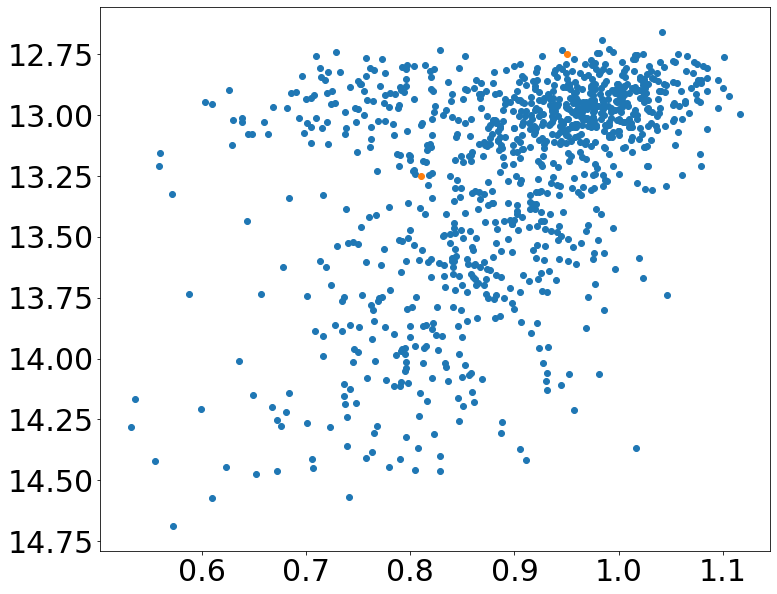

In [4]:
plt.figure(figsize=[12,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.scatter(0.81,13.25,c='tab:orange')
plt.scatter(0.95,12.75,c='tab:orange')
plt.gca().invert_yaxis()

 
-3.571 x + 16.14


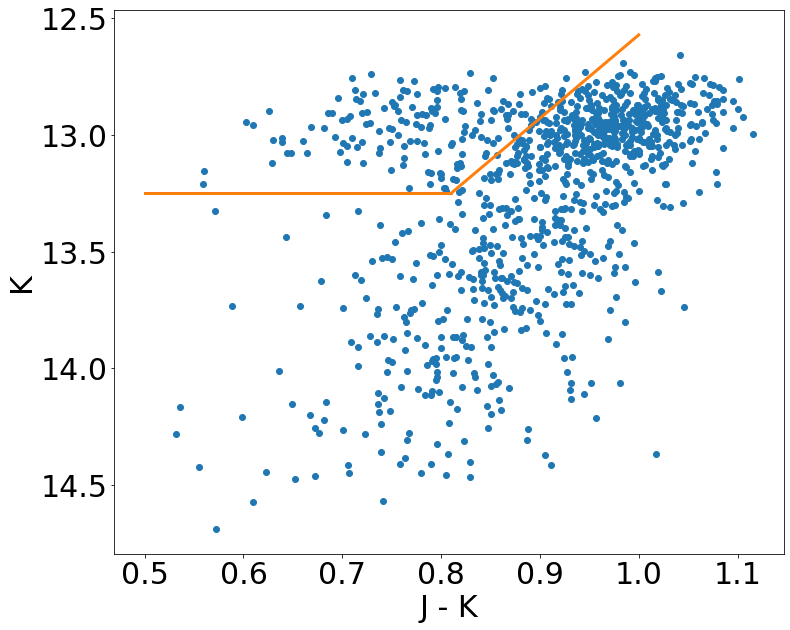

In [5]:
zbloop = np.polyfit([0.81,0.95], [13.25,12.75], 1)
pbloop = np.poly1d(zbloop)

print(pbloop)

plt.figure(figsize=[12,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.plot([0.81,1.0],[pbloop(0.81),pbloop(1.0)],c='tab:orange',lw=3.)
plt.plot([0.5,0.81],[13.25,13.25],c='tab:orange',lw=3.)

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.show()

In [6]:
def bloop(j_k):
    '''
    Function used to cut the bloop using apparent 2Mass colors. The return is the K on the boundary as a function
    of J - K color.
    
    Inputs:
    ------
    j_k: J - K 2Mass color
    
    Outputs:
    -------
    k: apparent 2Mass K of bloop cut 
    '''
    
    if j_k <= 0.81:
        return 13.25 #k
    else:
        return -3.571*j_k + 16.14
            

In [7]:
j_kcols = smc['J']-smc['K']

bloop_idx = []
for i in range(len(j_kcols)):
    if smc['K'][i] < bloop(j_kcols[i]):
        bloop_idx.append(int(i))

bloop_cut = []
for i in range(len(smc)):
    if i not in bloop_idx:
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

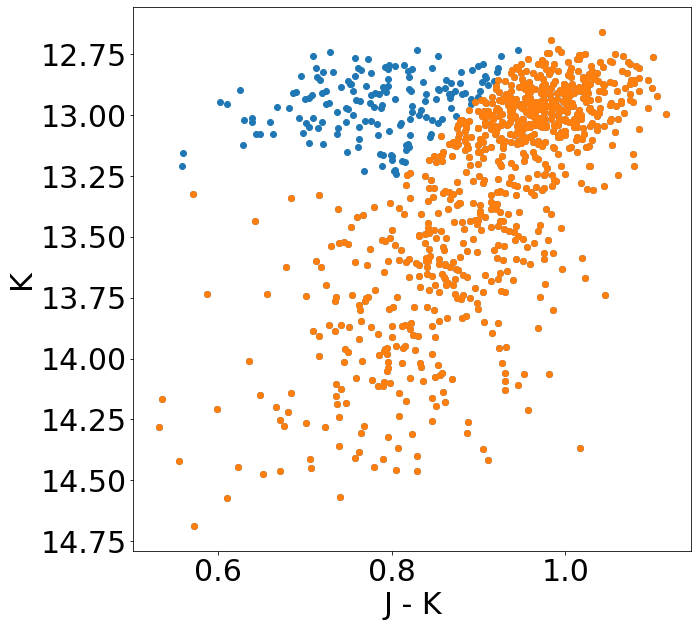

In [8]:
plt.figure(figsize=[10,10])
plt.scatter(smc['J']-smc['K'],smc['K'])
plt.scatter((smc_nobloop['J']-smc_nobloop['K']),smc_nobloop['K'])

plt.gca().invert_yaxis()

plt.xlabel(r'J - K')
plt.ylabel(r'K')

plt.show()

In [9]:
################################
### Individual APOGEE Fields ###
################################

# tuc47_ind = np.where(smc_nobloop['FIELD']=='47TUC')
# n362_ind = np.where(smc_nobloop['FIELD']=='N362')
# smc1_ind = np.where(smc_nobloop['FIELD']=='SMC1')
# smc2_ind = np.where(smc_nobloop['FIELD']=='SMC2')
# smc3_ind = np.where(smc_nobloop['FIELD']=='SMC3')
# smc4_ind = np.where(smc_nobloop['FIELD']=='SMC4')
# smc5_ind = np.where(smc_nobloop['FIELD']=='SMC5')
# smc6_ind = np.where(smc_nobloop['FIELD']=='SMC6')
# smc7_ind = np.where(smc_nobloop['FIELD']=='SMC7')

tuc47_ind = np.where(smc['FIELD']=='47TUC')
n362_ind = np.where(smc['FIELD']=='N362')
smc1_ind = np.where(smc['FIELD']=='SMC1')
smc2_ind = np.where(smc['FIELD']=='SMC2')
smc3_ind = np.where(smc['FIELD']=='SMC3')
smc4_ind = np.where(smc['FIELD']=='SMC4')
smc5_ind = np.where(smc['FIELD']=='SMC5')
smc6_ind = np.where(smc['FIELD']=='SMC6')
smc7_ind = np.where(smc['FIELD']=='SMC7')

field_idx = [tuc47_ind,n362_ind,smc1_ind,smc2_ind,smc3_ind,smc4_ind,smc5_ind,smc6_ind,smc7_ind]

In [10]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/apogee_smc_edr3-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


<font size='45'>
    <b>
        Kinematic Distances
    </b>
</font>

In [11]:
#################
### Functions ###
#################

def distance(mu,mu0,d0):
    '''
    Calculate the kinematic distance to a star assuming all stars have the same tangential velocity
    
    Inputs:
    ------
        mu: proper motion magnitude
        d0: ref distance
        mu0: ref proper motion magnitude in units of mu
        
    Output:
    ------
        d: distance to star in the same units of d0
    '''
    
    d = d0*np.divide(mu0,mu)
    
    return d

def euclid(x,y,h,k):
    '''
    Calculate the distance from some point (h,k)
    
    Inputs:
    ------
        x: x coordinate(s) of point(s)
        y: y coordinate(s) of point(s)
        h: x coordinate of reference point
        k: y coordinate of reference point
    
    Output:
    ------
        r: distance between (x,y) and (h,k)
    '''
    
    r = np.sqrt(np.subtract(x,h)**2+np.subtract(y,k)**2)
    
    return r

In [12]:
#################
### Red Clump ###
#################

rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

rc_pmmag = np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2)
rc_pmmag_uncertainty = np.sqrt(rc_gaia['pmra_error']**2+rc_gaia['pmdec_error']**2)
rc_pmmag_err = util.mad(rc_pmmag)

gaia47 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc[tuc47_ind]['RA']),
                                  np.median(smc[tuc47_ind]['DEC']))<=0.95)]
gaia362 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc[n362_ind]['RA']),
                                   np.median(smc[n362_ind]['DEC']))<=0.95)]
gaia1 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc1_ind]['RA']),
                                 np.median(smc[smc1_ind]['DEC']))<=0.95)]
gaia2 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc2_ind]['RA']),
                                 np.median(smc[smc2_ind]['DEC']))<=0.95)]
gaia3 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc3_ind]['RA']),
                                 np.median(smc[smc3_ind]['DEC']))<=0.95)]
gaia4 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc4_ind]['RA']),
                                 np.median(smc[smc4_ind]['DEC']))<=0.95)]
gaia5 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc5_ind]['RA']),
                                 np.median(smc[smc5_ind]['DEC']))<=0.95)]
gaia6 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc6_ind]['RA']),
                                 np.median(smc[smc6_ind]['DEC']))<=0.95)]
gaia7 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc[smc7_ind]['RA']),
                                 np.median(smc[smc7_ind]['DEC']))<=0.95)]

rc47 = gaia47[np.where((gaia47['bp_rp']<1.2)&(gaia47['bp_rp']>0.8)&(gaia47['phot_g_mean_mag']<19.55)&
                (gaia47['phot_g_mean_mag']>18.9))]

rc362 = gaia362[np.where((gaia362['bp_rp']<1.2)&(gaia362['bp_rp']>0.6)&(gaia362['phot_g_mean_mag']<19.65)&
                 (gaia362['phot_g_mean_mag']>18.7))]

rc1 = gaia1[np.where((gaia1['bp_rp']<1.2)&(gaia1['bp_rp']>0.85)&(gaia1['phot_g_mean_mag']<19.55)&
               (gaia1['phot_g_mean_mag']>18.8))]

rc2 = gaia2[np.where((gaia2['bp_rp']<1.2)&(gaia2['bp_rp']>0.9)&(gaia2['phot_g_mean_mag']<19.55)&
               (gaia2['phot_g_mean_mag']>18.8))]

rc3 = gaia3[np.where((gaia3['bp_rp']<1.2)&(gaia3['bp_rp']>0.65)&(gaia3['phot_g_mean_mag']<19.55)&
               (gaia3['phot_g_mean_mag']>18.8))]

rc4 = gaia4[np.where((gaia4['bp_rp']<1.2)&(gaia4['bp_rp']>0.7)&(gaia4['phot_g_mean_mag']<19.6)&
               (gaia4['phot_g_mean_mag']>18.75))]

rc5 = gaia5[np.where((gaia5['bp_rp']<1.2)&(gaia5['bp_rp']>0.85)&(gaia5['phot_g_mean_mag']<19.6)&
               (gaia5['phot_g_mean_mag']>18.75))]

rc6 = gaia6[np.where((gaia6['bp_rp']<1.2)&(gaia6['bp_rp']>0.85)&(gaia6['phot_g_mean_mag']<19.55)&
               (gaia6['phot_g_mean_mag']>18.55))]

rc7 = gaia7[np.where((gaia7['bp_rp']<1.2)&(gaia7['bp_rp']>0.85)&(gaia7['phot_g_mean_mag']<19.55)&
               (gaia7['phot_g_mean_mag']>18.55))]

rcs = [rc47,rc362,rc1,rc2,rc3,rc4,rc5,rc6,rc7]

In [13]:
rc_mu_fields = [np.sqrt(rc47['pmra']**2+rc47['pmdec']**2),np.sqrt(rc362['pmra']**2+rc362['pmdec']**2),
                np.sqrt(rc1['pmra']**2+rc1['pmdec']**2),np.sqrt(rc2['pmra']**2+rc2['pmdec']**2),
                np.sqrt(rc3['pmra']**2+rc3['pmdec']**2),np.sqrt(rc4['pmra']**2+rc4['pmdec']**2),
                np.sqrt(rc5['pmra']**2+rc5['pmdec']**2),np.sqrt(rc6['pmra']**2+rc6['pmdec']**2),
                np.sqrt(rc7['pmra']**2+rc7['pmdec']**2)]

rc_mu_fields_err = [np.sqrt(gaia47['pmra_error']**2+gaia47['pmdec_error']**2),
                    np.sqrt(gaia362['pmra_error']**2+gaia362['pmdec_error']**2),
                    np.sqrt(gaia1['pmra_error']**2+gaia1['pmdec_error']**2),
                    np.sqrt(gaia2['pmra_error']**2+gaia2['pmdec_error']**2),
                    np.sqrt(gaia3['pmra_error']**2+gaia3['pmdec_error']**2),
                    np.sqrt(gaia4['pmra_error']**2+gaia4['pmdec_error']**2),
                    np.sqrt(gaia5['pmra_error']**2+gaia5['pmdec_error']**2),
                    np.sqrt(gaia6['pmra_error']**2+gaia6['pmdec_error']**2),
                    np.sqrt(gaia7['pmra_error']**2+gaia7['pmdec_error']**2)]

# rc_vel_fields = []
# rc_vel_fields_err = []
# for i in range(len(rc_mu_fields)):
#     rc_vel_fields.append(60*4.74*rc_mu_fields[i])
#     rc_vel_fields_err.append(60*4.74*rc_mu_fields_err[i])

In [14]:
#############################################################
### Add 27 km/s Dispersion to Field Tangential Velocities ###
#############################################################

tuc47_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(tuc47_ind)))):
    mu = np.sqrt(smc[tuc47_ind]['GAIA_PMRA'][i]**2+smc[tuc47_ind]['GAIA_PMDEC'][i]**2)
    tuc47_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

n362_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(n362_ind)))):
    mu = np.sqrt(smc[n362_ind]['GAIA_PMRA'][i]**2+smc[n362_ind]['GAIA_PMDEC'][i]**2)
    n362_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc1_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc1_ind)))):
    mu = np.sqrt(smc[smc1_ind]['GAIA_PMRA'][i]**2+smc[smc1_ind]['GAIA_PMDEC'][i]**2)
    smc1_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc2_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc2_ind)))):
    mu = np.sqrt(smc[smc2_ind]['GAIA_PMRA'][i]**2+smc[smc2_ind]['GAIA_PMDEC'][i]**2)
    smc2_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))
    
smc3_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc3_ind)))):
    mu = np.sqrt(smc[smc3_ind]['GAIA_PMRA'][i]**2+smc[smc3_ind]['GAIA_PMDEC'][i]**2)
    smc3_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc4_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc4_ind)))):
    mu = np.sqrt(smc[smc4_ind]['GAIA_PMRA'][i]**2+smc[smc4_ind]['GAIA_PMDEC'][i]**2)
    smc4_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc5_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc5_ind)))):
    mu = np.sqrt(smc[smc5_ind]['GAIA_PMRA'][i]**2+smc[smc5_ind]['GAIA_PMDEC'][i]**2)
    smc5_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc6_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc6_ind)))):
    mu = np.sqrt(smc[smc6_ind]['GAIA_PMRA'][i]**2+smc[smc6_ind]['GAIA_PMDEC'][i]**2)
    smc6_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

smc7_dist27 = []
for i in tqdm_notebook(range(len(np.squeeze(smc7_ind)))):
    mu = np.sqrt(smc[smc7_ind]['GAIA_PMRA'][i]**2+smc[smc7_ind]['GAIA_PMDEC'][i]**2)
    smc7_dist27.append(np.random.normal(4.74*60*np.median(rc_mu_fields[0]),27,100)/(4.74*mu))

In [15]:
# for i in tqdm_notebook(tuc47_dist27)

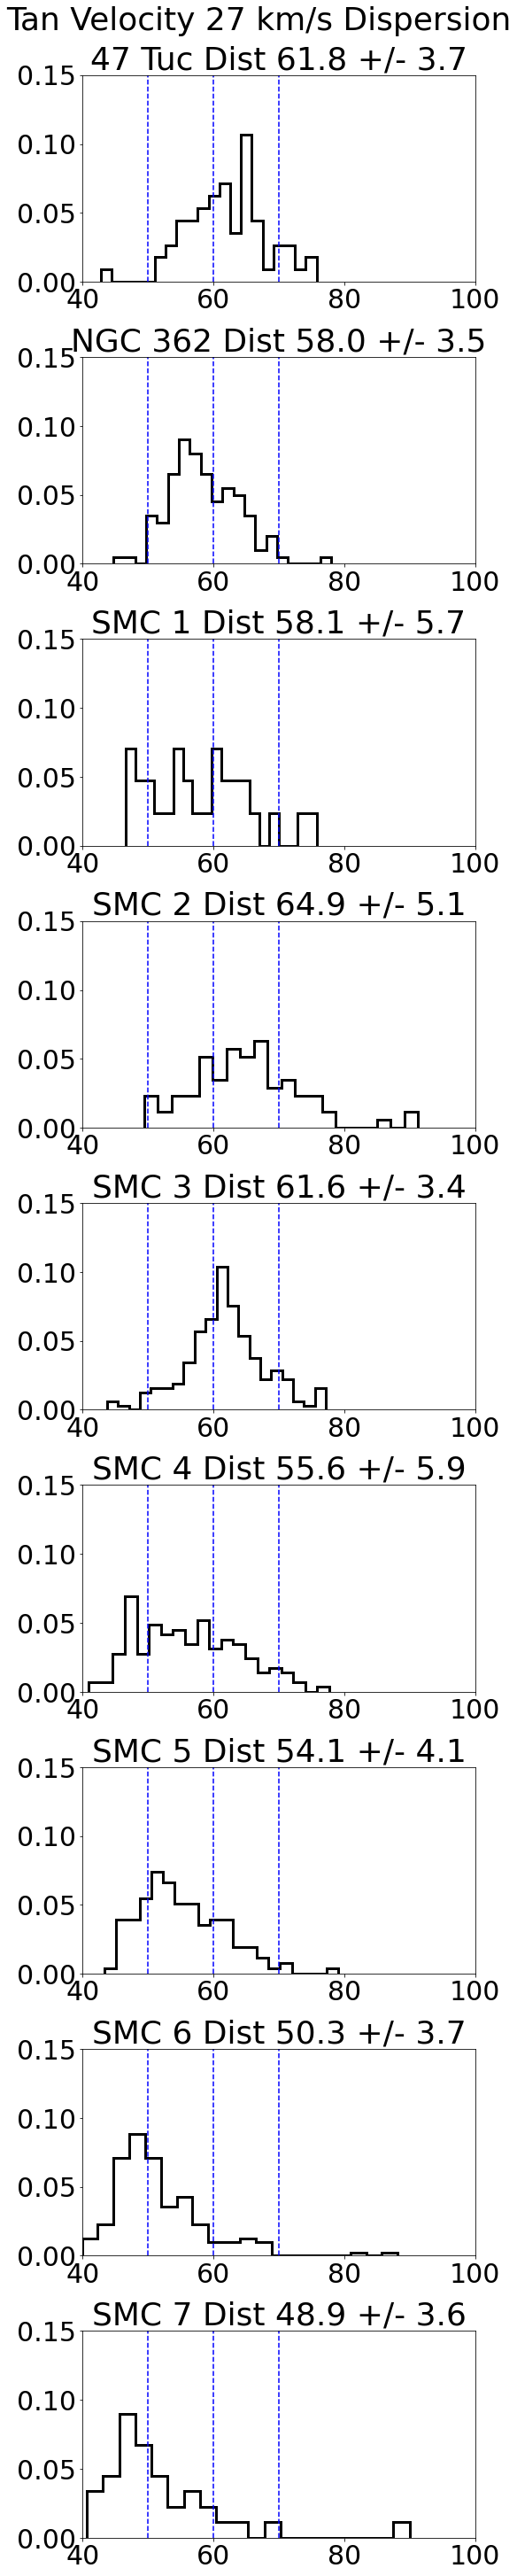

In [16]:
distance_dist = [np.median(tuc47_dist27,1),np.median(n362_dist27,1),np.median(smc1_dist27,1),
                 np.median(smc2_dist27,1),np.median(smc3_dist27,1),np.median(smc4_dist27,1),
                 np.median(smc5_dist27,1),np.median(smc6_dist27,1),np.median(smc7_dist27,1)]
distance_dist_disp = [util.mad(tuc47_dist27),util.mad(n362_dist27),util.mad(smc1_dist27),
                      util.mad(smc2_dist27),util.mad(smc3_dist27),util.mad(smc4_dist27),
                      util.mad(smc5_dist27),util.mad(smc6_dist27),util.mad(smc7_dist27)]
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(distance_dist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.15)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_dist[i]),
                                                        util.mad(distance_dist[i])))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle(r'Tan Velocity 27 km/s Dispersion',y=1.01)
plt.tight_layout(pad=0.5)

plt.show()

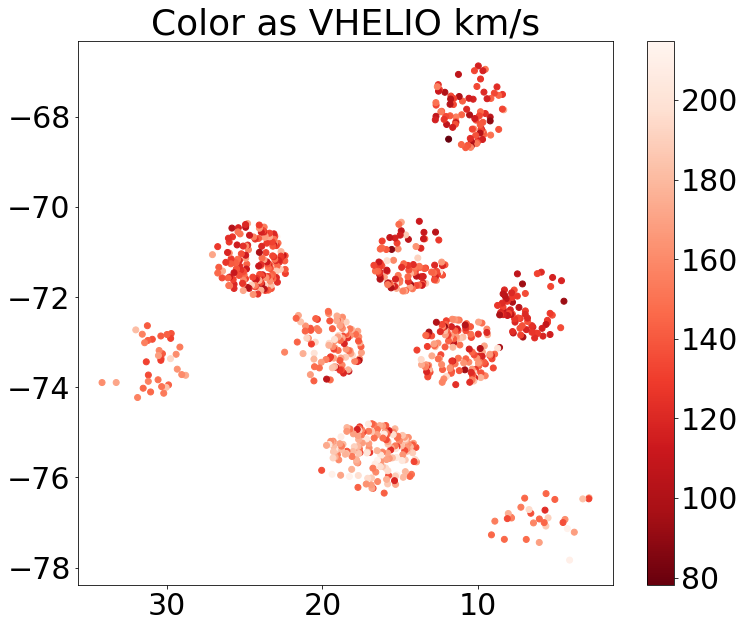

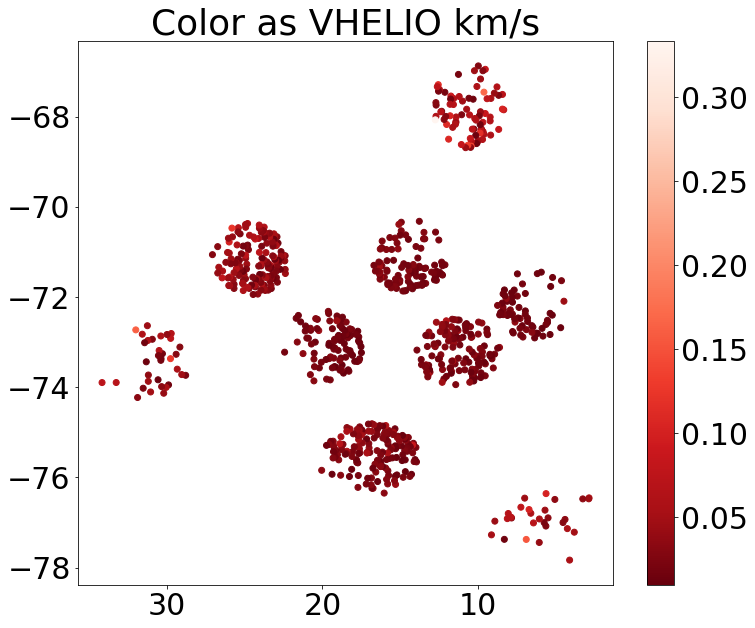

In [17]:
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],c=smc_nobloop['VHELIO_AVG'],cmap='Reds_r')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as VHELIO km/s')

plt.show()

plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],c=smc_nobloop['VERR'],cmap='Reds_r')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as VHELIO km/s')

plt.show()

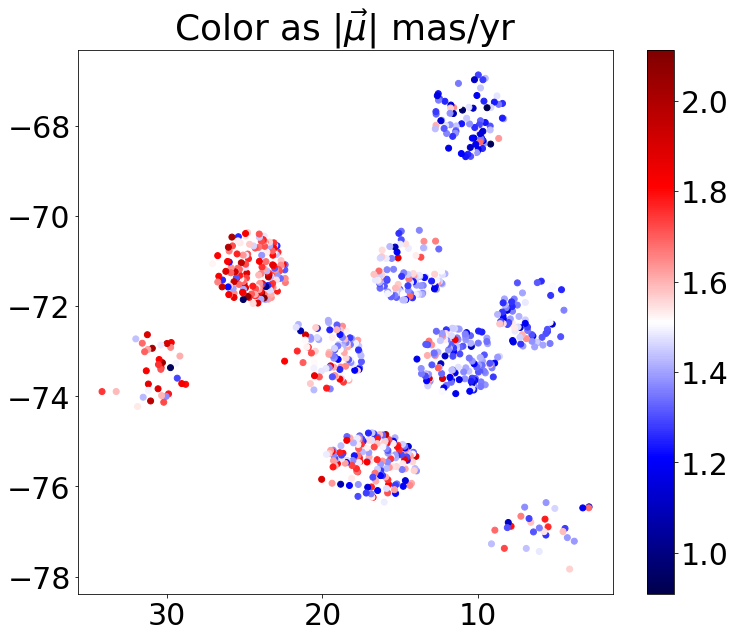

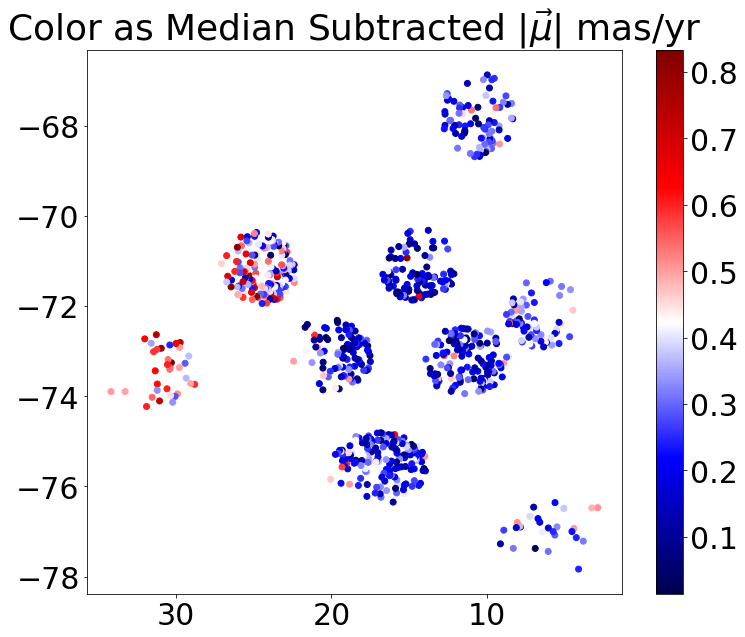

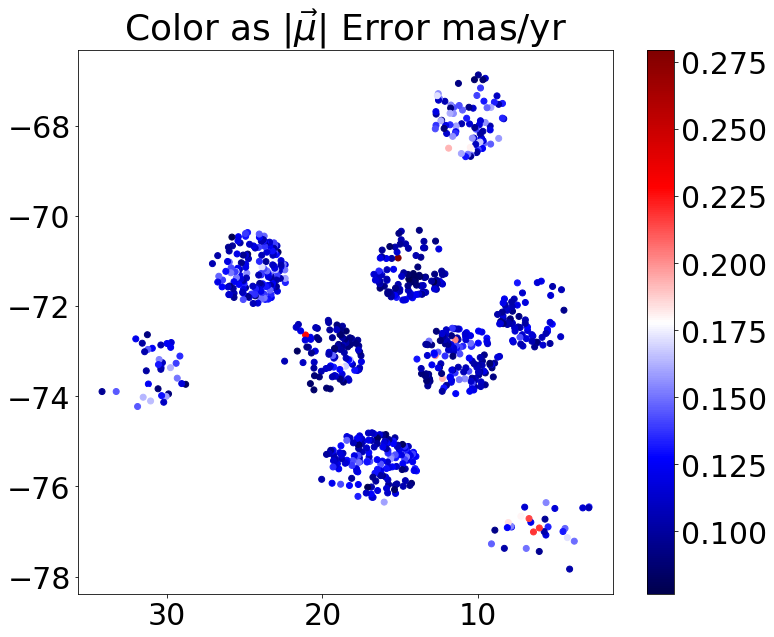

In [18]:
### Proper Motion Magnitude
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA']**2+smc_nobloop['GAIA_PMDEC']**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as $|\vec{\mu}|$ mas/yr')

plt.show()

### Median Subtracted
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt((smc_nobloop['GAIA_PMRA']-np.median(smc_nobloop['GAIA_PMRA']))**2+
                      (smc_nobloop['GAIA_PMDEC']-np.median(smc_nobloop['GAIA_PMDEC']))**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Median Subtracted $|\vec{\mu}|$ mas/yr')

plt.show()

### Error 
plt.figure(figsize=[12,10])
plt.scatter(smc_nobloop['RA'],smc_nobloop['DEC'],
            c=np.sqrt(smc_nobloop['GAIA_PMRA_ERROR']**2+smc_nobloop['GAIA_PMDEC_ERROR']**2),cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as $|\vec{\mu}|$ Error mas/yr')

plt.show()

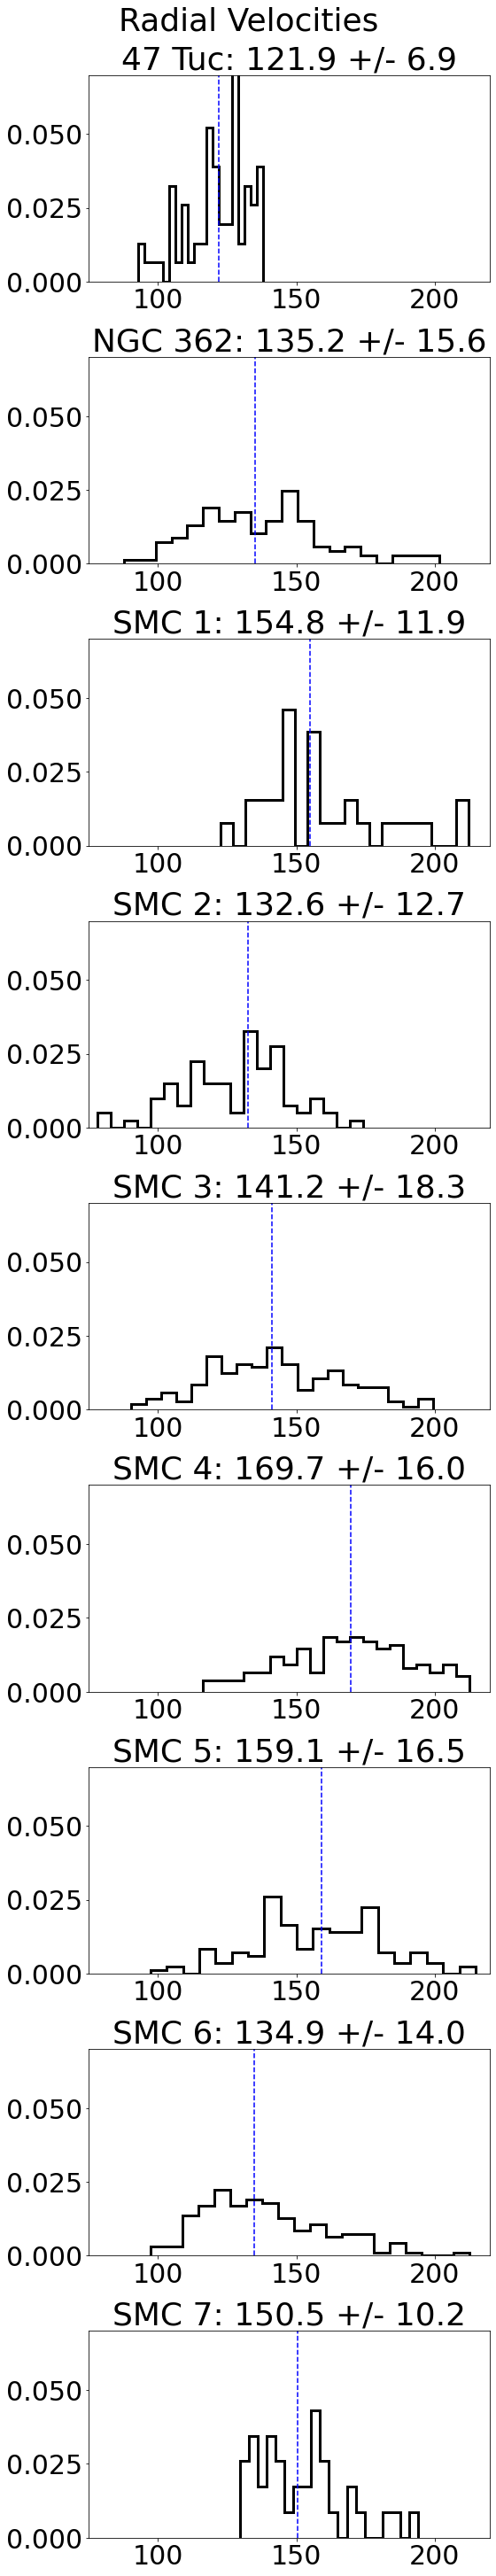

In [19]:
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(smc['VHELIO_AVG'][field_idx[i]],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
#     ax[i].legend()
    
    ax[i].set_ylim(top=0.07)
    ax[i].set_xlim(75,220)
    
    ax[i].set_title(r'{}: {:.1f} +/- {:.1f}'.format(distance_label[i],
                                                   np.median(smc['VHELIO_AVG'][field_idx[i]]),
                                                    util.mad(smc['VHELIO_AVG'][field_idx[i]])))
    
    ax[i].axvline(np.median(smc['VHELIO_AVG'][field_idx[i]]),ls='--',c='b')

plt.suptitle(r'Radial Velocities',y=1.01)
plt.tight_layout(pad=0.5)

plt.show()

<font size='45'>
    <b>
        Photometric Distances
    </b>
</font>

Assume that the overall median distance of all the red clump stars is 60 kpc away

In [20]:
#distance modulus of smc at 60 kpc
mod60 = 5*np.log10(60000)-5
print('60 kpc dm: ', mod60)

#calculate median absolute magnitude using 
med_abs = np.median(rc_gaia['phot_g_mean_mag'])-mod60
print('Expected Abs G of RC: ',med_abs)

#Field distances 
dist_phot47 = 10**((rc47['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot362 = 10**((rc362['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot1 = 10**((rc1['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot2 = 10**((rc2['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot3 = 10**((rc3['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot4 = 10**((rc4['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot5 = 10**((rc5['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot6 = 10**((rc6['phot_g_mean_mag']-med_abs)/5.+1)/1000
dist_phot7 = 10**((rc7['phot_g_mean_mag']-med_abs)/5.+1)/1000


60 kpc dm:  18.89075625191822
Expected Abs G of RC:  0.317350742710687


In [21]:
rcsubapogee = []
for i in range(len(rcs)):
    rcsubapogee.append(np.median(rcs[i]['phot_g_mean_mag'])-np.median(smc[field_idx[i]]['GAIA_GMAG']))

In [22]:
print(np.asarray(rcsubapogee))

[3.1016083 3.1153202 2.6386528 2.5965424 3.1650887 2.884182  3.247427
 2.6300583 2.5880852]


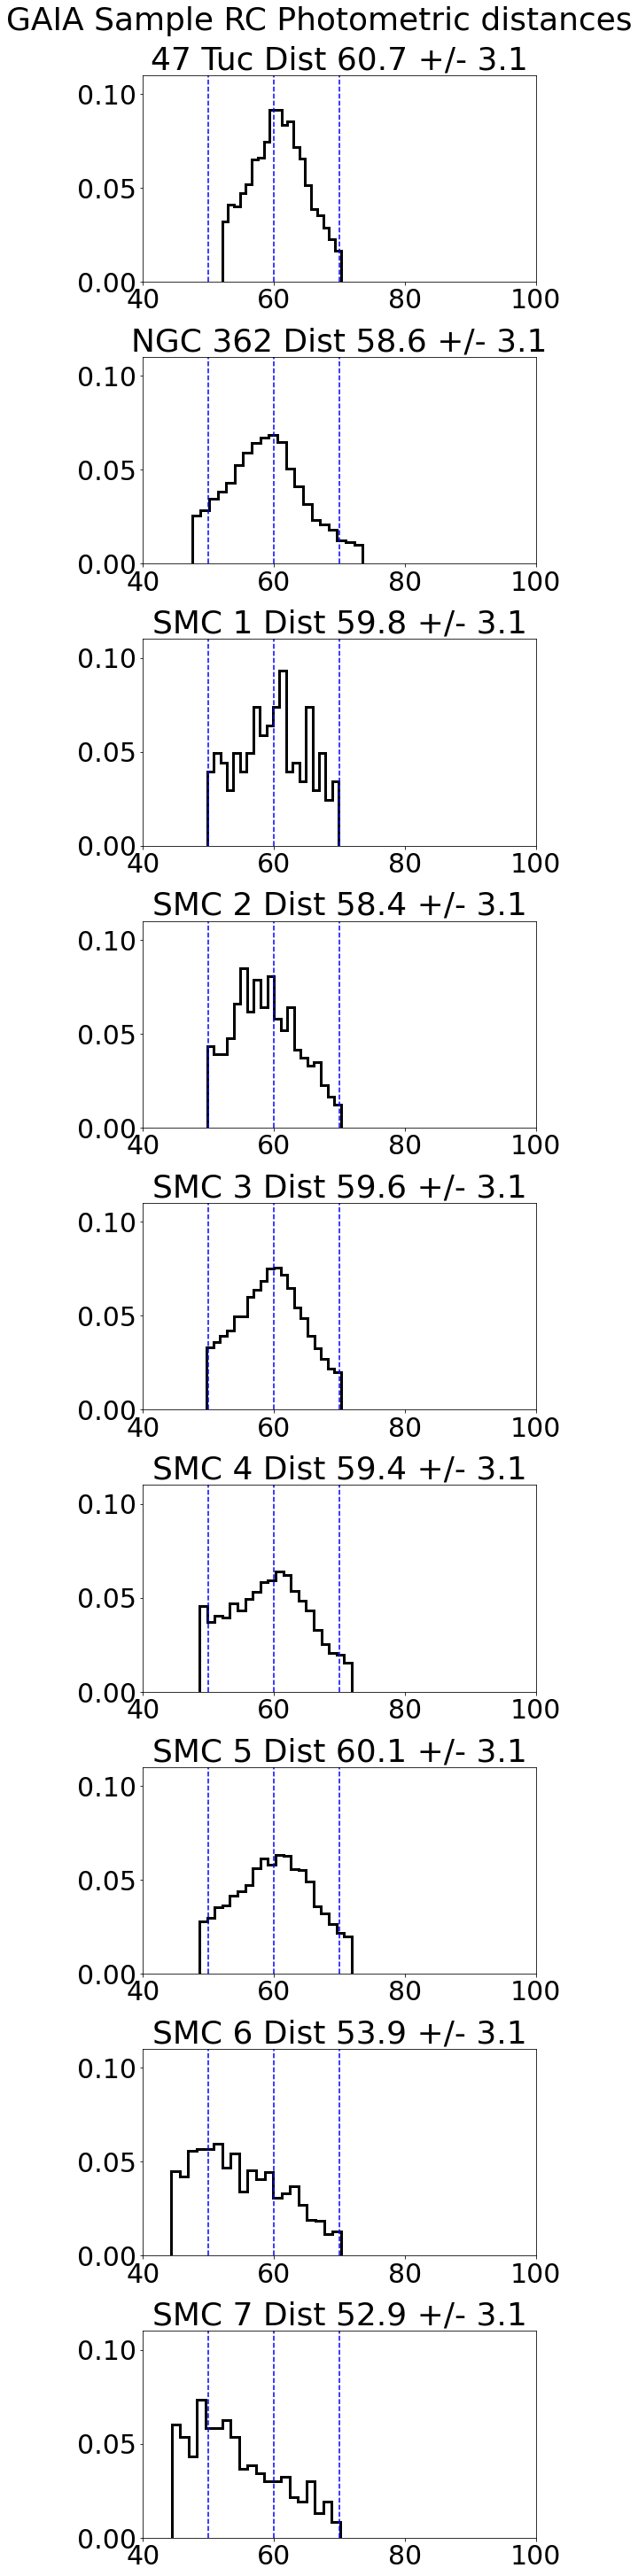

In [23]:
phot_dist = [dist_phot47,dist_phot362,dist_phot1,dist_phot2,dist_phot3,dist_phot4,dist_phot5,dist_phot6,
             dist_phot7]
phot_dist_disp = [util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47),
                      util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47),
                      util.mad(dist_phot47),util.mad(dist_phot47),util.mad(dist_phot47)]
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(phot_dist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.11)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(phot_dist[i]),
                                                        phot_dist_disp[i]))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle(r'GAIA Sample RC Photometric distances',y=1.01)
plt.tight_layout(pad=0.5)

plt.show()

In [24]:
### phot distance using DR1 0.44 RC Abs Mag calibration 
gmag_list = [rc47['phot_g_mean_mag'],rc362['phot_g_mean_mag'],rc1['phot_g_mean_mag'],rc2['phot_g_mean_mag'],
             rc3['phot_g_mean_mag'],rc4['phot_g_mean_mag'],rc5['phot_g_mean_mag'],rc6['phot_g_mean_mag'],
             rc7['phot_g_mean_mag']]
dr1_dist = []
dr1_dist_err = []
for i in gmag_list:
    dr1_dist.append(10**((np.asarray(i)-0.44)/5.+1))
    dr1_dist_err.append(util.mad(10**((np.asarray(i)-0.44)/5.+1)))
    
dr1_meds = []
for i in range(len(dr1_dist)):
    dr1_meds.append(np.median(dr1_dist[i]))

### find offset such that the median rc phot distance is 60 kpc
offset = 60000 - np.median(dr1_meds)
offset_err = np.abs(-1)*dr1_dist_err

### RC field d0 distance for EDR3
dist_edr3_meds = dr1_meds+offset
dist_edr3_meds_err = np.multiply(np.sqrt(2),dr1_dist_err)

<font size='45'>
    <b>
        Photo-Kinematic Distance
    </b>
</font>

Assumptions: 1) all stars in each field have essentially the same tangential motion 2) the overall median distance across the smc for the RC stars is at 60 kpc

In [25]:
tuc47_kpdist27 = []
tuc47_kpdist27_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[0]/1000.*np.median(rc_mu_fields[0]),27,100)
    d = tanv/(4.74*mu)
    tuc47_kpdist27.append(d)
    tuc47_kpdist27_errs.append(util.mad(d))
    
n362_kpdist27 = []
n362_kpdist27_errs = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[1]/1000.*np.median(rc_mu_fields[1]),27,100)
    d = tanv/(4.74*mu)
    n362_kpdist27.append(d)
    n362_kpdist27_errs.append(util.mad(d))
    
smc1_kpdist27 = []
smc1_kpdist27_errs = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[2]/1000.*np.median(rc_mu_fields[2]),27,100)
    d = tanv/(4.74*mu)
    smc1_kpdist27.append(d)
    smc1_kpdist27_errs.append(util.mad(d))
    
smc2_kpdist27 = []
smc2_kpdist27_errs = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[3]/1000.*np.median(rc_mu_fields[3]),27,100)
    d = tanv/(4.74*mu)
    smc2_kpdist27.append(d)
    smc2_kpdist27_errs.append(util.mad(d))
    
smc3_kpdist27 = []
smc3_kpdist27_errs = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[4]/1000.*np.median(rc_mu_fields[4]),27,100)
    d = tanv/(4.74*mu)
    smc3_kpdist27.append(d)
    smc3_kpdist27_errs.append(util.mad(d))
    
smc4_kpdist27 = []
smc4_kpdist27_errs = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[5]/1000.*np.median(rc_mu_fields[5]),27,100)
    d = tanv/(4.74*mu)
    smc4_kpdist27.append(d)
    smc4_kpdist27_errs.append(util.mad(d))
    
smc5_kpdist27 = []
smc5_kpdist27_errs = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[6]/1000.*np.median(rc_mu_fields[6]),27,100)
    d = tanv/(4.74*mu)
    smc5_kpdist27.append(d)
    smc5_kpdist27_errs.append(util.mad(d))
    
smc6_kpdist27 = []
smc6_kpdist27_errs = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[7]/1000.*np.median(rc_mu_fields[7]),27,100)
    d = tanv/(4.74*mu)
    smc6_kpdist27.append(d)
    smc6_kpdist27_errs.append(util.mad(d))
    
smc7_kpdist27 = []
smc7_kpdist27_errs = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    tanv = np.random.normal(4.74*dist_edr3_meds[8]/1000.*np.median(rc_mu_fields[8]),27,100)
    d = tanv/(4.74*mu)
    smc7_kpdist27.append(d)
    smc7_kpdist27_errs.append(util.mad(d))

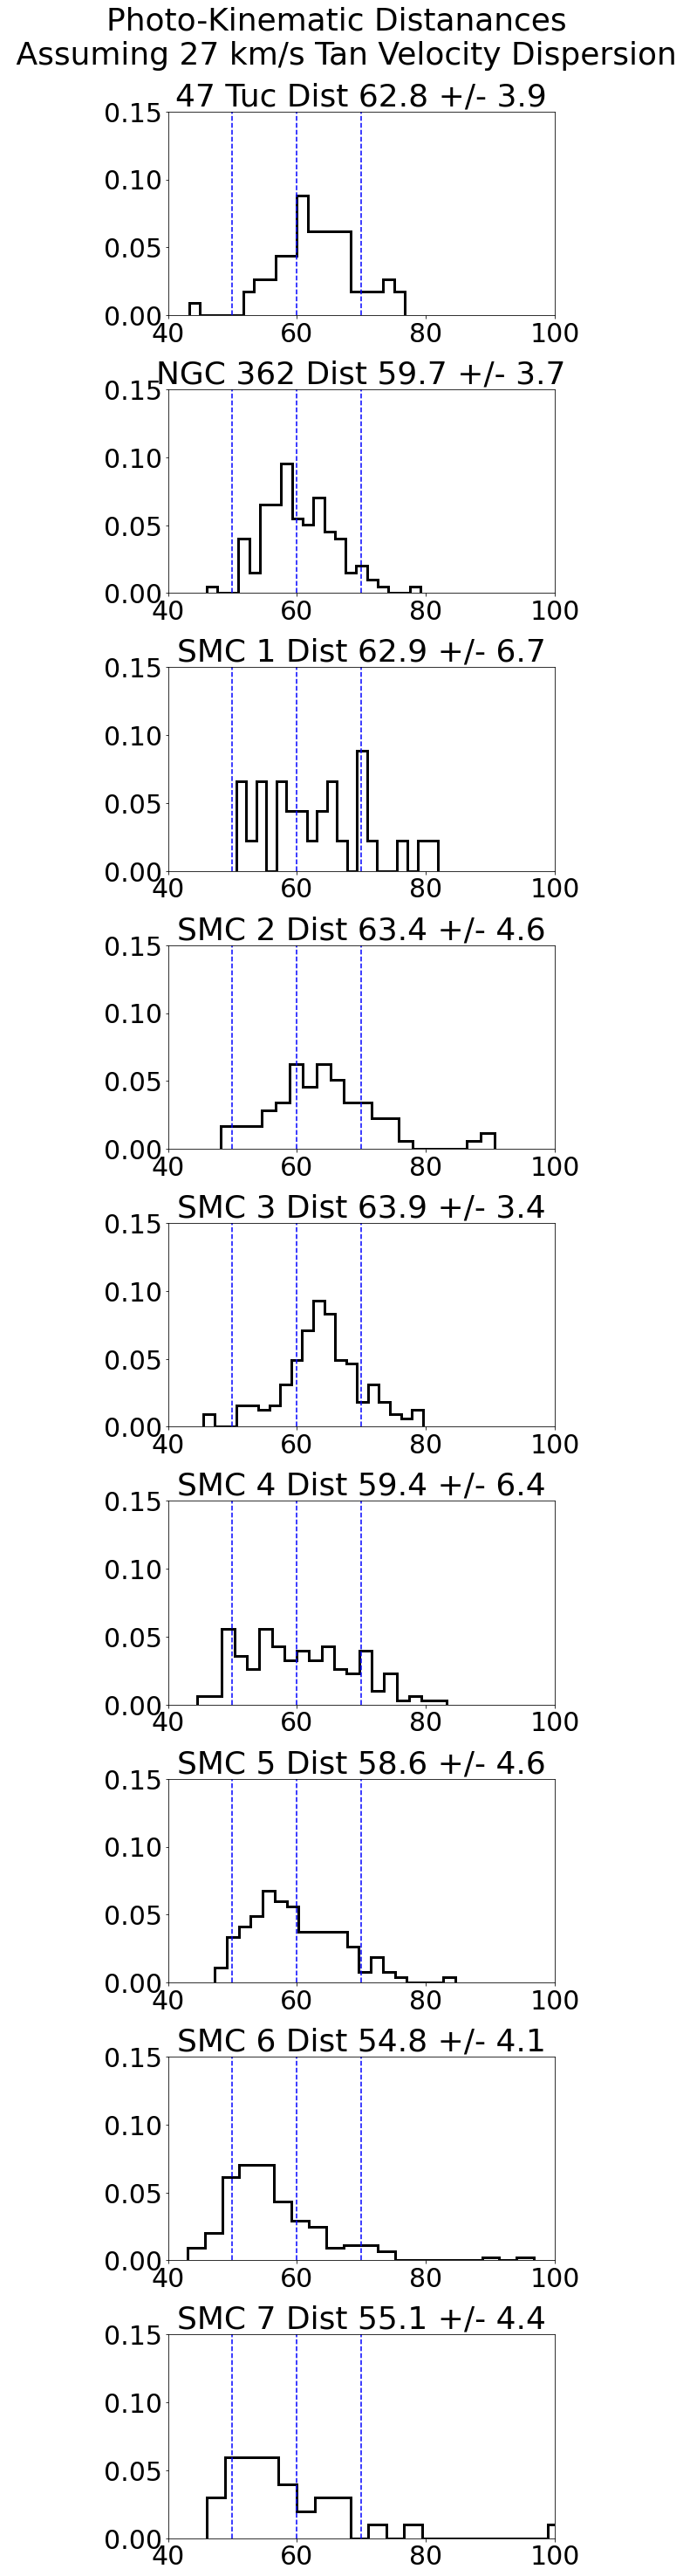

In [26]:
distance_kpdist = [np.median(tuc47_kpdist27,1),np.median(n362_kpdist27,1),np.median(smc1_kpdist27,1),
                 np.median(smc2_kpdist27,1),np.median(smc3_kpdist27,1),np.median(smc4_kpdist27,1),
                 np.median(smc5_kpdist27,1),np.median(smc6_kpdist27,1),np.median(smc7_kpdist27,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdist27),util.mad(n362_kpdist27),util.mad(smc1_kpdist27),
                      util.mad(smc2_kpdist27),util.mad(smc3_kpdist27),util.mad(smc4_kpdist27),
                      util.mad(smc5_kpdist27),util.mad(smc6_kpdist27),util.mad(smc7_kpdist27)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,1,figsize=[8,40])

for i in range(len(ax)):
    ax[i].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i].set_ylim(top=0.15)
    ax[i].set_xlim(40,100)

    
    ax[i].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i].axvline(50,ls='--',c='b')
    ax[i].axvline(60,ls='--',c='b')
    ax[i].axvline(70,ls='--',c='b')

plt.suptitle('Photo-Kinematic Distanances \n Assuming 27 km/s Tan Velocity Dispersion',y=1.025)
plt.tight_layout(pad=0.5)

plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

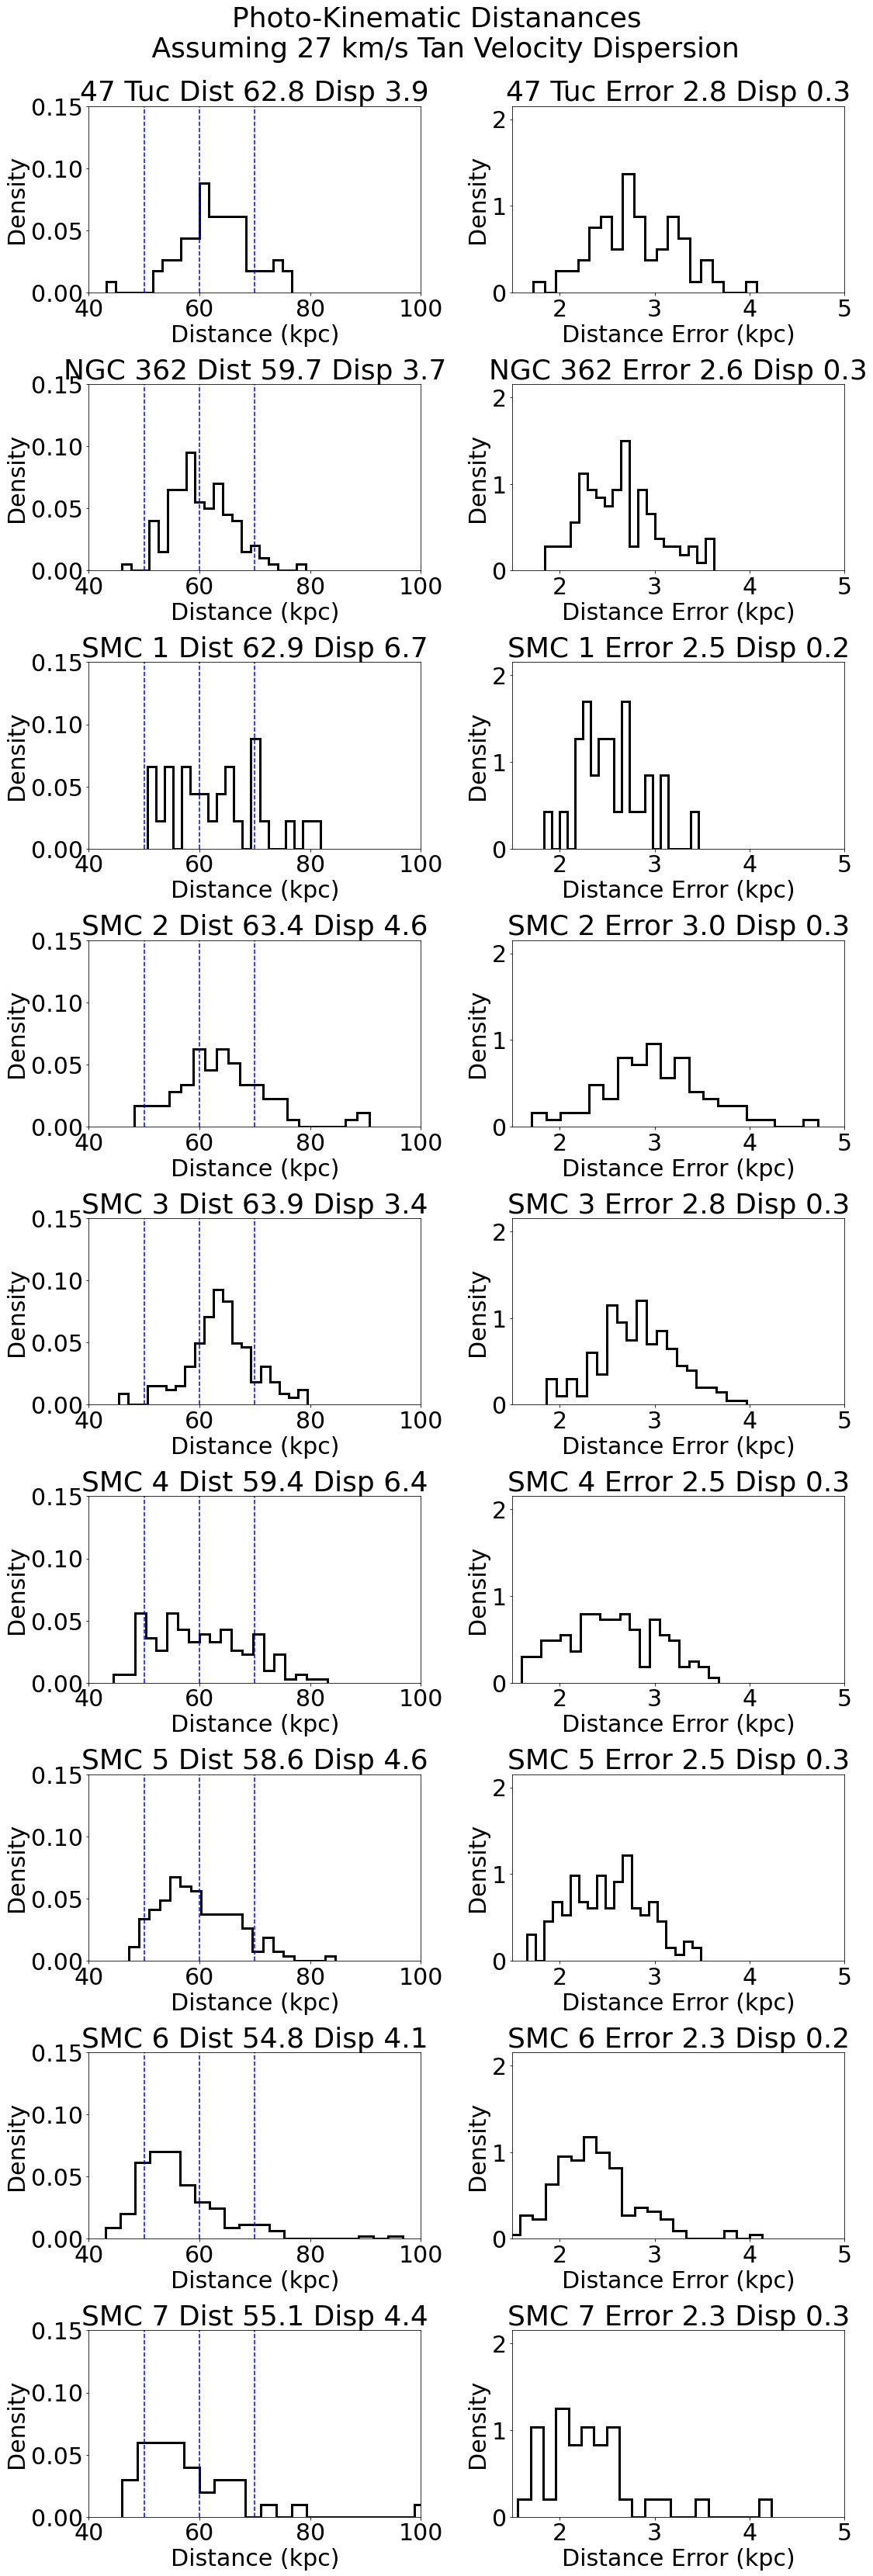

In [27]:
distance_kpdist = [np.median(tuc47_kpdist27,1),np.median(n362_kpdist27,1),np.median(smc1_kpdist27,1),
                 np.median(smc2_kpdist27,1),np.median(smc3_kpdist27,1),np.median(smc4_kpdist27,1),
                 np.median(smc5_kpdist27,1),np.median(smc6_kpdist27,1),np.median(smc7_kpdist27,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdist27),util.mad(n362_kpdist27),util.mad(smc1_kpdist27),
                      util.mad(smc2_kpdist27),util.mad(smc3_kpdist27),util.mad(smc4_kpdist27),
                      util.mad(smc5_kpdist27),util.mad(smc6_kpdist27),util.mad(smc7_kpdist27)]

distance_kpdist_err = [tuc47_kpdist27_errs,n362_kpdist27_errs,smc1_kpdist27_errs,smc2_kpdist27_errs,
                       smc3_kpdist27_errs,smc4_kpdist27_errs,smc5_kpdist27_errs,smc6_kpdist27_errs,
                       smc7_kpdist27_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdist27_errs),util.mad(n362_kpdist27_errs),
                            util.mad(smc1_kpdist27_errs),util.mad(smc2_kpdist27_errs),
                            util.mad(smc3_kpdist27_errs),util.mad(smc4_kpdist27_errs),
                            util.mad(smc5_kpdist27_errs),util.mad(smc6_kpdist27_errs),
                            util.mad(smc7_kpdist27_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.15)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=2.15)
    ax[i][1].set_xlim(1.5,5.0)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    
#     ax[i][1].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
#                                                         util.mad(distance_kpdist[i])))
    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                            util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances \n Assuming 27 km/s Tan Velocity Dispersion',y=1.025)
plt.tight_layout(pad=0.5)

# plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

In [28]:
# ra = []
# dec = []
# kpmed = []
# kpmed_disp = []
# for i in range(len(field_idx)):
#     ra.append(np.median(smc[field_idx[i]]['RA']))
#     dec.append(np.median(smc[field_idx[i]]['DEC']))
#     kpmed.append(np.median(distance_kpdist[i]))
#     kpmed_disp.append(util.mad(distance_kpdist[i]))
    

# ra = np.asarray(ra)
# dec = np.asarray(dec)
# # radius = 0.95*np.ones(len(field))

# plt.figure(figsize=[12,10])
# for j in range(len(field_idx)):
#     plt.scatter(ra,dec,c=kpmed,cmap='seismic',s=1000,vmax=max(kpmed),vmin=min(kpmed))
# plt.colorbar()
# plt.gca().invert_xaxis()

# plt.title(r'Color as Median Photo-Kinematic Distance [kpc]')

# plt.show()

In [29]:
### 47 Tuc
smc47field = []
smc47mads = []
for i in range(len(np.squeeze(tuc47_ind))):
    smc47field.append('47TUC')
    smc47mads.append(util.mad(tuc47_kpdist27[i]))

tsmc47 = Table()
col_id = Column(np.asarray(smc[tuc47_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc47field),name='FIELD')
col_distance = Column(np.median(tuc47_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc47mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(tuc47_kpdist27),name='DISTANCE_DIST')

tsmc47.add_column(col_id)
tsmc47.add_column(col_field)
tsmc47.add_column(col_distance)
tsmc47.add_column(col_dev)
tsmc47.add_column(col_dist)

### NGC 362
smc362field = []
smc362mads = []
for i in range(len(np.squeeze(n362_ind))):
    smc362field.append('N362')
    smc362mads.append(util.mad(n362_kpdist27[i]))

tsmc362 = Table()
col_id = Column(np.asarray(smc[n362_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc362field),name='FIELD')
col_distance = Column(np.median(n362_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc362mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(n362_kpdist27),name='DISTANCE_DIST')

tsmc362.add_column(col_id)
tsmc362.add_column(col_field)
tsmc362.add_column(col_distance)
tsmc362.add_column(col_dev)
tsmc362.add_column(col_dist)

### SMC 1
smc1field = []
smc1mads = []
for i in range(len(np.squeeze(smc1_ind))):
    smc1field.append('SMC1')
    smc1mads.append(util.mad(smc1_kpdist27[i]))

tsmc1 = Table()
col_id = Column(np.asarray(smc[smc1_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc1field),name='FIELD')
col_distance = Column(np.median(smc1_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc1mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc1_kpdist27),name='DISTANCE_DIST')

tsmc1.add_column(col_id)
tsmc1.add_column(col_field)
tsmc1.add_column(col_distance)
tsmc1.add_column(col_dev)
tsmc1.add_column(col_dist)

### SMC 2
smc2field = []
smc2mads = []
for i in range(len(np.squeeze(smc2_ind))):
    smc2field.append('SMC2')
    smc2mads.append(util.mad(smc2_kpdist27[i]))

tsmc2 = Table()
col_id = Column(np.asarray(smc[smc2_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc2field),name='FIELD')
col_distance = Column(np.median(smc2_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc2mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc2_kpdist27),name='DISTANCE_DIST')

tsmc2.add_column(col_id)
tsmc2.add_column(col_field)
tsmc2.add_column(col_distance)
tsmc2.add_column(col_dev)
tsmc2.add_column(col_dist)

### SMC 3
smc3field = []
smc3mads = []
for i in range(len(np.squeeze(smc3_ind))):
    smc3field.append('SMC3')
    smc3mads.append(util.mad(smc3_kpdist27[i]))
    
tsmc3 = Table()
col_id = Column(np.asarray(smc[smc3_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc3field),name='FIELD')
col_distance = Column(np.median(smc3_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc3mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc3_kpdist27),name='DISTANCE_DIST')

tsmc3.add_column(col_id)
tsmc3.add_column(col_field)
tsmc3.add_column(col_distance)
tsmc3.add_column(col_dev)
tsmc3.add_column(col_dist)

### SMC 4
smc4field = []
smc4mads = []
for i in range(len(np.squeeze(smc4_ind))):
    smc4field.append('SMC4')
    smc4mads.append(util.mad(smc4_kpdist27[i]))
    
tsmc4 = Table()
col_id = Column(np.asarray(smc[smc4_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc4field),name='FIELD')
col_distance = Column(np.median(smc4_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc4mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc4_kpdist27),name='DISTANCE_DIST')

tsmc4.add_column(col_id)
tsmc4.add_column(col_field)
tsmc4.add_column(col_distance)
tsmc4.add_column(col_dev)
tsmc4.add_column(col_dist)

### SMC 5
smc5field = []
smc5mads = []
for i in range(len(np.squeeze(smc5_ind))):
    smc5field.append('SMC5')
    smc5mads.append(util.mad(smc5_kpdist27[i]))

tsmc5 = Table()
col_id = Column(np.asarray(smc[smc5_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc5field),name='FIELD')
col_distance = Column(np.median(smc5_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc5mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc5_kpdist27),name='DISTANCE_DIST')

tsmc5.add_column(col_id)
tsmc5.add_column(col_field)
tsmc5.add_column(col_distance)
tsmc5.add_column(col_dev)
tsmc5.add_column(col_dist)

### SMC 6
smc6field = []
smc6mads = []
for i in range(len(np.squeeze(smc6_ind))):
    smc6field.append('SMC6')
    smc6mads.append(util.mad(smc6_kpdist27[i]))

tsmc6 = Table()
col_id = Column(np.asarray(smc[smc6_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc6field),name='FIELD')
col_distance = Column(np.median(smc6_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc6mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc6_kpdist27),name='DISTANCE_DIST')

tsmc6.add_column(col_id)
tsmc6.add_column(col_field)
tsmc6.add_column(col_distance)
tsmc6.add_column(col_dev)
tsmc6.add_column(col_dist)

### SMC 7
smc7field = []
smc7mads = []
for i in range(len(np.squeeze(smc7_ind))):
    smc7field.append('SMC7')
    smc7mads.append(util.mad(smc7_kpdist27[i]))

tsmc7 = Table()
col_id = Column(np.asarray(smc[smc7_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc7field),name='FIELD')
col_distance = Column(np.median(smc7_kpdist27,1),name='DISTANCE')
col_dev = Column(np.asarray(smc7mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc7_kpdist27),name='DISTANCE_DIST')

tsmc7.add_column(col_id)
tsmc7.add_column(col_field)
tsmc7.add_column(col_distance)
tsmc7.add_column(col_dev)
tsmc7.add_column(col_dist)

### order matches original smc file 
distance_table = vstack([tsmc3,tsmc362,tsmc5,tsmc47,tsmc4,tsmc6,tsmc1,tsmc2,tsmc7])

# distance_table.write('smc_photokinematic_distances.fits',format='fits',overwrite=True)

In [30]:
calc_distance = fits.getdata('smc_photokinematic_distances.fits',0)
calc_distance.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'FIELD'; format = '5A'
    name = 'DISTANCE'; format = 'D'
    name = 'DISTANCE_ERR'; format = 'D'
    name = 'DISTANCE_DIST'; format = '100D'; dim = '(100)'
)

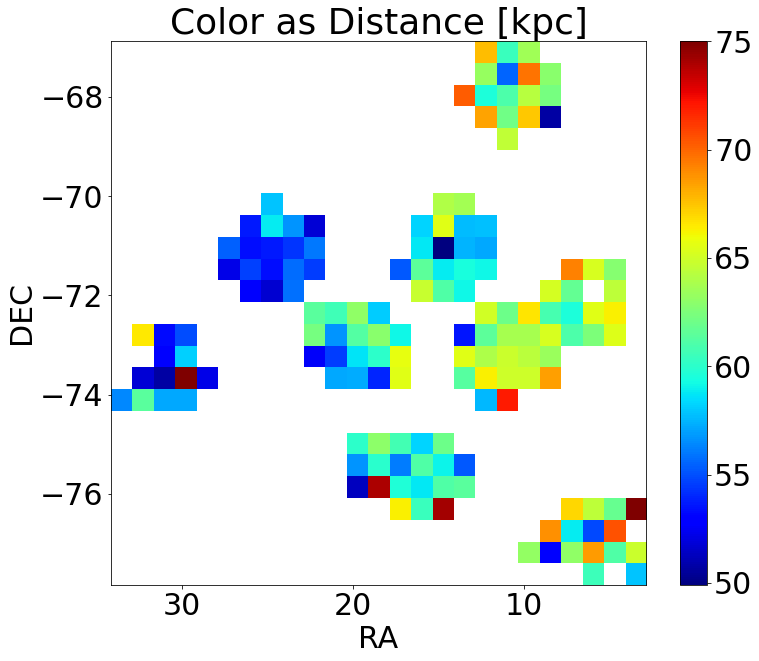

In [31]:
from scipy.stats import binned_statistic_2d
distmed = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance['DISTANCE'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(distmed.statistic.T, origin='lower',
           extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map.pdf',bbox_inches='tight')
plt.show()

<font size='45'>
    <b>
        Photo-Kinematic Distance PM &amp; PM0 Errors
    </b>
</font>

In [32]:
tuc47_kpdistpm0 = []
tuc47_kpdistpm0_errs = []
tuc47_kpdistpm = []
tuc47_kpdistpm_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[0]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[0]),np.median(rc_mu_fields_err[0]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[0]),denom)
    
    tuc47_kpdistpm0.append(dpm0)
    tuc47_kpdistpm0_errs.append(util.mad(dpm0))
    tuc47_kpdistpm.append(dpm)
    tuc47_kpdistpm_errs.append(util.mad(dpm))
    
n362_kpdistpm0 = []
n362_kpdistpm0_errs = []
n362_kpdistpm = []
n362_kpdistpm_errs = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[1]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[1]),np.median(rc_mu_fields_err[1]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[1]),denom)

    n362_kpdistpm0.append(dpm0)
    n362_kpdistpm0_errs.append(util.mad(dpm0))
    n362_kpdistpm.append(dpm)
    n362_kpdistpm_errs.append(util.mad(dpm))
    
smc1_kpdistpm0 = []
smc1_kpdistpm0_errs = []
smc1_kpdistpm = []
smc1_kpdistpm_errs = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[2]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[2]),np.median(rc_mu_fields_err[2]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[2]),denom)
    
    smc1_kpdistpm0.append(dpm0)
    smc1_kpdistpm0_errs.append(util.mad(dpm0))
    smc1_kpdistpm.append(dpm)
    smc1_kpdistpm_errs.append(util.mad(dpm))
    
smc2_kpdistpm0 = []
smc2_kpdistpm0_errs = []
smc2_kpdistpm = []
smc2_kpdistpm_errs = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[3]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[3]),np.median(rc_mu_fields_err[3]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[3]),denom)
    
    smc2_kpdistpm0.append(dpm0)
    smc2_kpdistpm0_errs.append(util.mad(dpm0))
    smc2_kpdistpm.append(dpm)
    smc2_kpdistpm_errs.append(util.mad(dpm))
    
smc3_kpdistpm0 = []
smc3_kpdistpm0_errs = []
smc3_kpdistpm = []
smc3_kpdistpm_errs = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[4]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[4]),np.median(rc_mu_fields_err[4]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[4]),denom)
    
    smc3_kpdistpm0.append(dpm0)
    smc3_kpdistpm0_errs.append(util.mad(dpm0))
    smc3_kpdistpm.append(dpm)
    smc3_kpdistpm_errs.append(util.mad(dpm))
    
smc4_kpdistpm0 = []
smc4_kpdistpm0_errs = []
smc4_kpdistpm = []
smc4_kpdistpm_errs = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[5]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[5]),np.median(rc_mu_fields_err[5]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[5]),denom)
    
    smc4_kpdistpm0.append(dpm0)
    smc4_kpdistpm0_errs.append(util.mad(dpm0))
    smc4_kpdistpm.append(dpm)
    smc4_kpdistpm_errs.append(util.mad(dpm))
    
smc5_kpdistpm0 = []
smc5_kpdistpm0_errs = []
smc5_kpdistpm = []
smc5_kpdistpm_errs = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[6]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[6]),np.median(rc_mu_fields_err[6]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[6]),denom)
    
    smc5_kpdistpm0.append(dpm0)
    smc5_kpdistpm0_errs.append(util.mad(dpm0))
    smc5_kpdistpm.append(dpm)
    smc5_kpdistpm_errs.append(util.mad(dpm))
    
smc6_kpdistpm0 = []
smc6_kpdistpm0_errs = []
smc6_kpdistpm = []
smc6_kpdistpm_errs = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[7]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[7]),np.median(rc_mu_fields_err[7]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[7]),denom)
    
    smc6_kpdistpm0.append(dpm0)
    smc6_kpdistpm0_errs.append(util.mad(dpm0))
    smc6_kpdistpm.append(dpm)
    smc6_kpdistpm_errs.append(util.mad(dpm))
    
smc7_kpdistpm0 = []
smc7_kpdistpm0_errs = []
smc7_kpdistpm = []
smc7_kpdistpm_errs = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    d0 = dist_edr3_meds[8]/1000.
    
    # Gaussian Noise
    numer0 = np.random.normal(np.median(rc_mu_fields[8]),np.median(rc_mu_fields_err[8]),100)
    denom = np.random.normal(mu,mu_err,100)
    
    # Calculate Distances with Errors
    dpm0 = d0*np.divide(numer0,mu)
    dpm = d0*np.divide(np.median(rc_mu_fields[8]),denom)
    
    smc7_kpdistpm0.append(dpm0)
    smc7_kpdistpm0_errs.append(util.mad(dpm0))
    smc7_kpdistpm.append(dpm)
    smc7_kpdistpm_errs.append(util.mad(dpm))

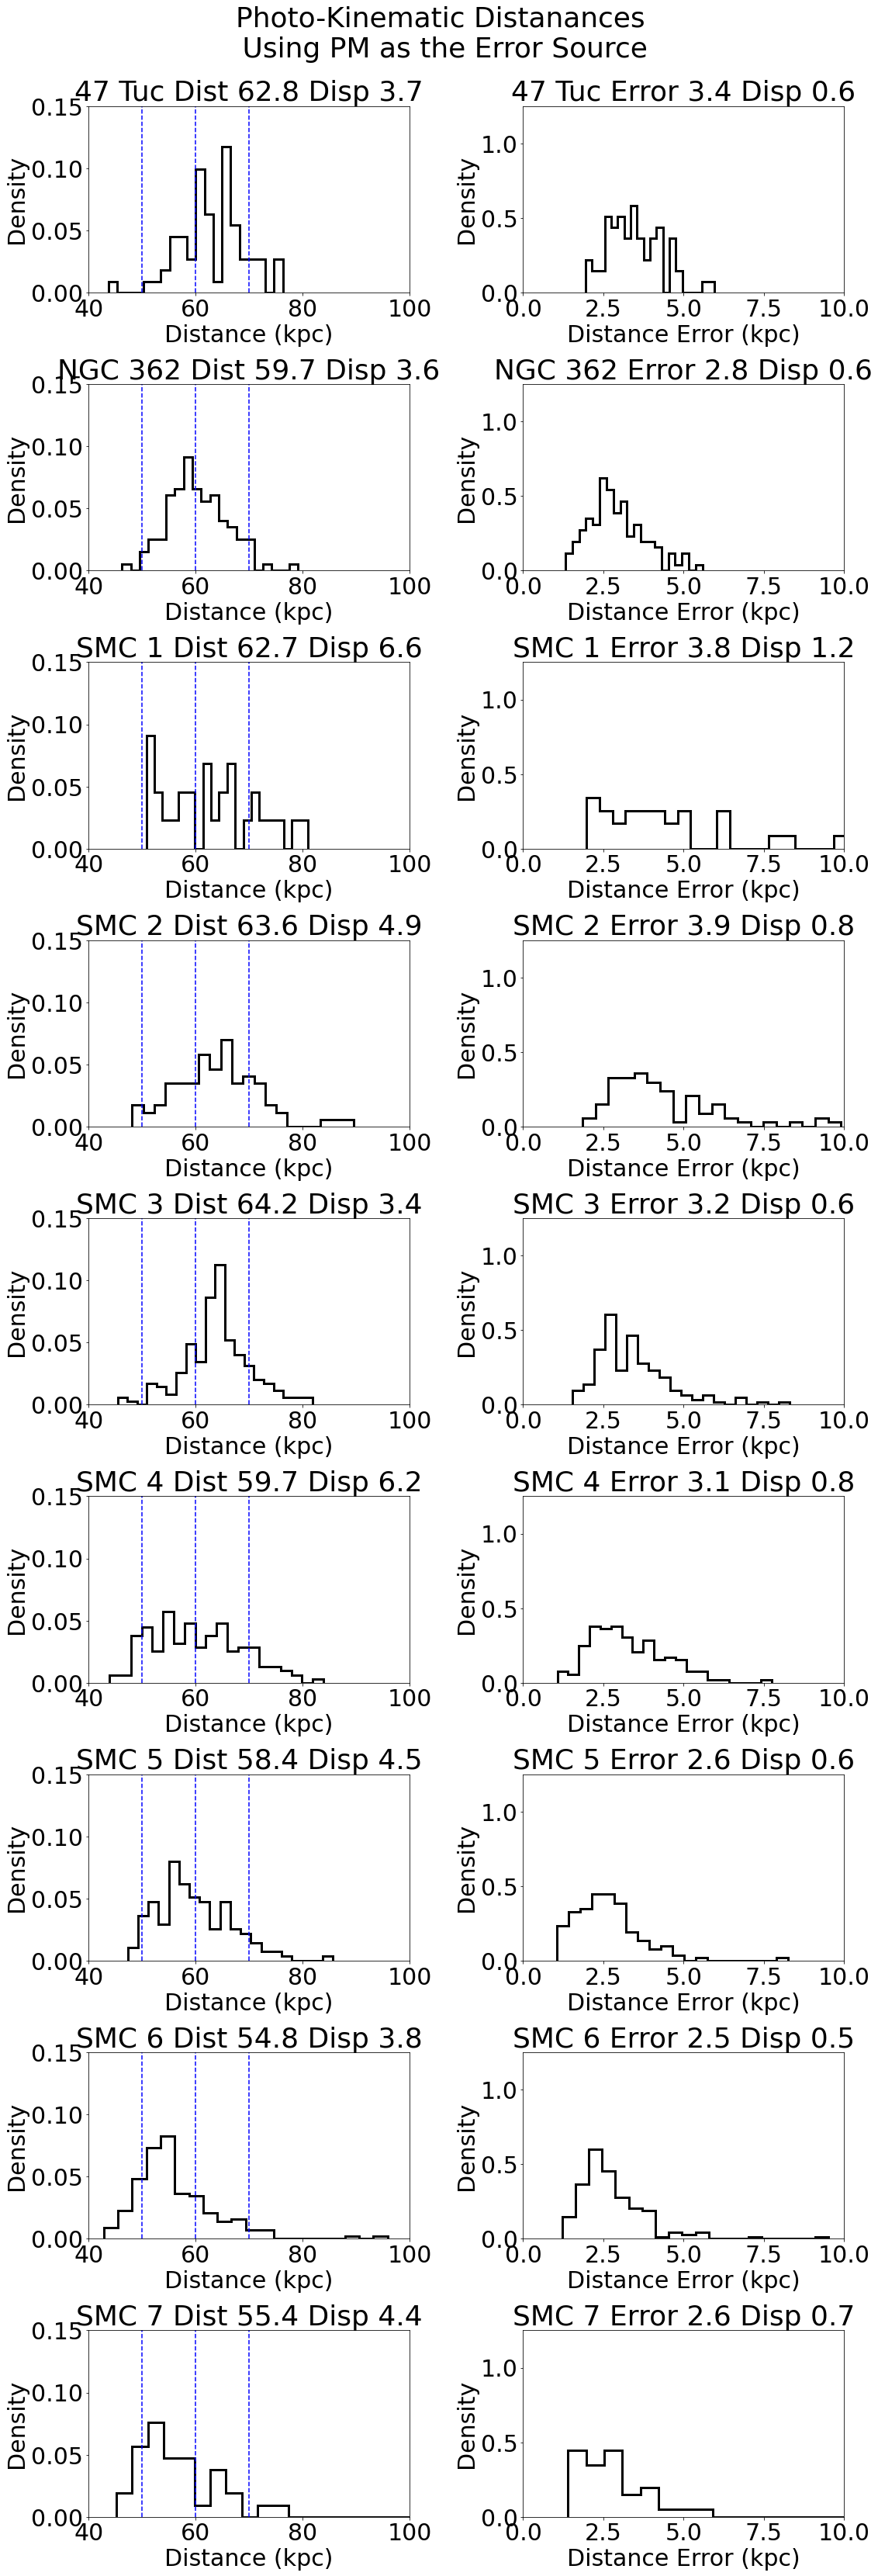

In [33]:
distance_kpdist = [np.median(tuc47_kpdistpm,1),np.median(n362_kpdistpm,1),np.median(smc1_kpdistpm,1),
                 np.median(smc2_kpdistpm,1),np.median(smc3_kpdistpm,1),np.median(smc4_kpdistpm,1),
                 np.median(smc5_kpdistpm,1),np.median(smc6_kpdistpm,1),np.median(smc7_kpdistpm,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdistpm),util.mad(n362_kpdistpm),util.mad(smc1_kpdistpm),
                      util.mad(smc2_kpdistpm),util.mad(smc3_kpdistpm),util.mad(smc4_kpdistpm),
                      util.mad(smc5_kpdistpm),util.mad(smc6_kpdistpm),util.mad(smc7_kpdistpm)]

distance_kpdist_err = [tuc47_kpdistpm_errs,n362_kpdistpm_errs,smc1_kpdistpm_errs,smc2_kpdistpm_errs,
                       smc3_kpdistpm_errs,smc4_kpdistpm_errs,smc5_kpdistpm_errs,smc6_kpdistpm_errs,
                       smc7_kpdistpm_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdistpm_errs),util.mad(n362_kpdistpm_errs),
                            util.mad(smc1_kpdistpm_errs),util.mad(smc2_kpdistpm_errs),
                            util.mad(smc3_kpdistpm_errs),util.mad(smc4_kpdistpm_errs),
                            util.mad(smc5_kpdistpm_errs),util.mad(smc6_kpdistpm_errs),
                            util.mad(smc7_kpdistpm_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.15)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=1.25)
    ax[i][1].set_xlim(0.,10.)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    
#     ax[i][1].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
#                                                         util.mad(distance_kpdist[i])))
    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                            util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances\n Using PM as the Error Source',y=1.025)
plt.tight_layout(pad=0.5)

# plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

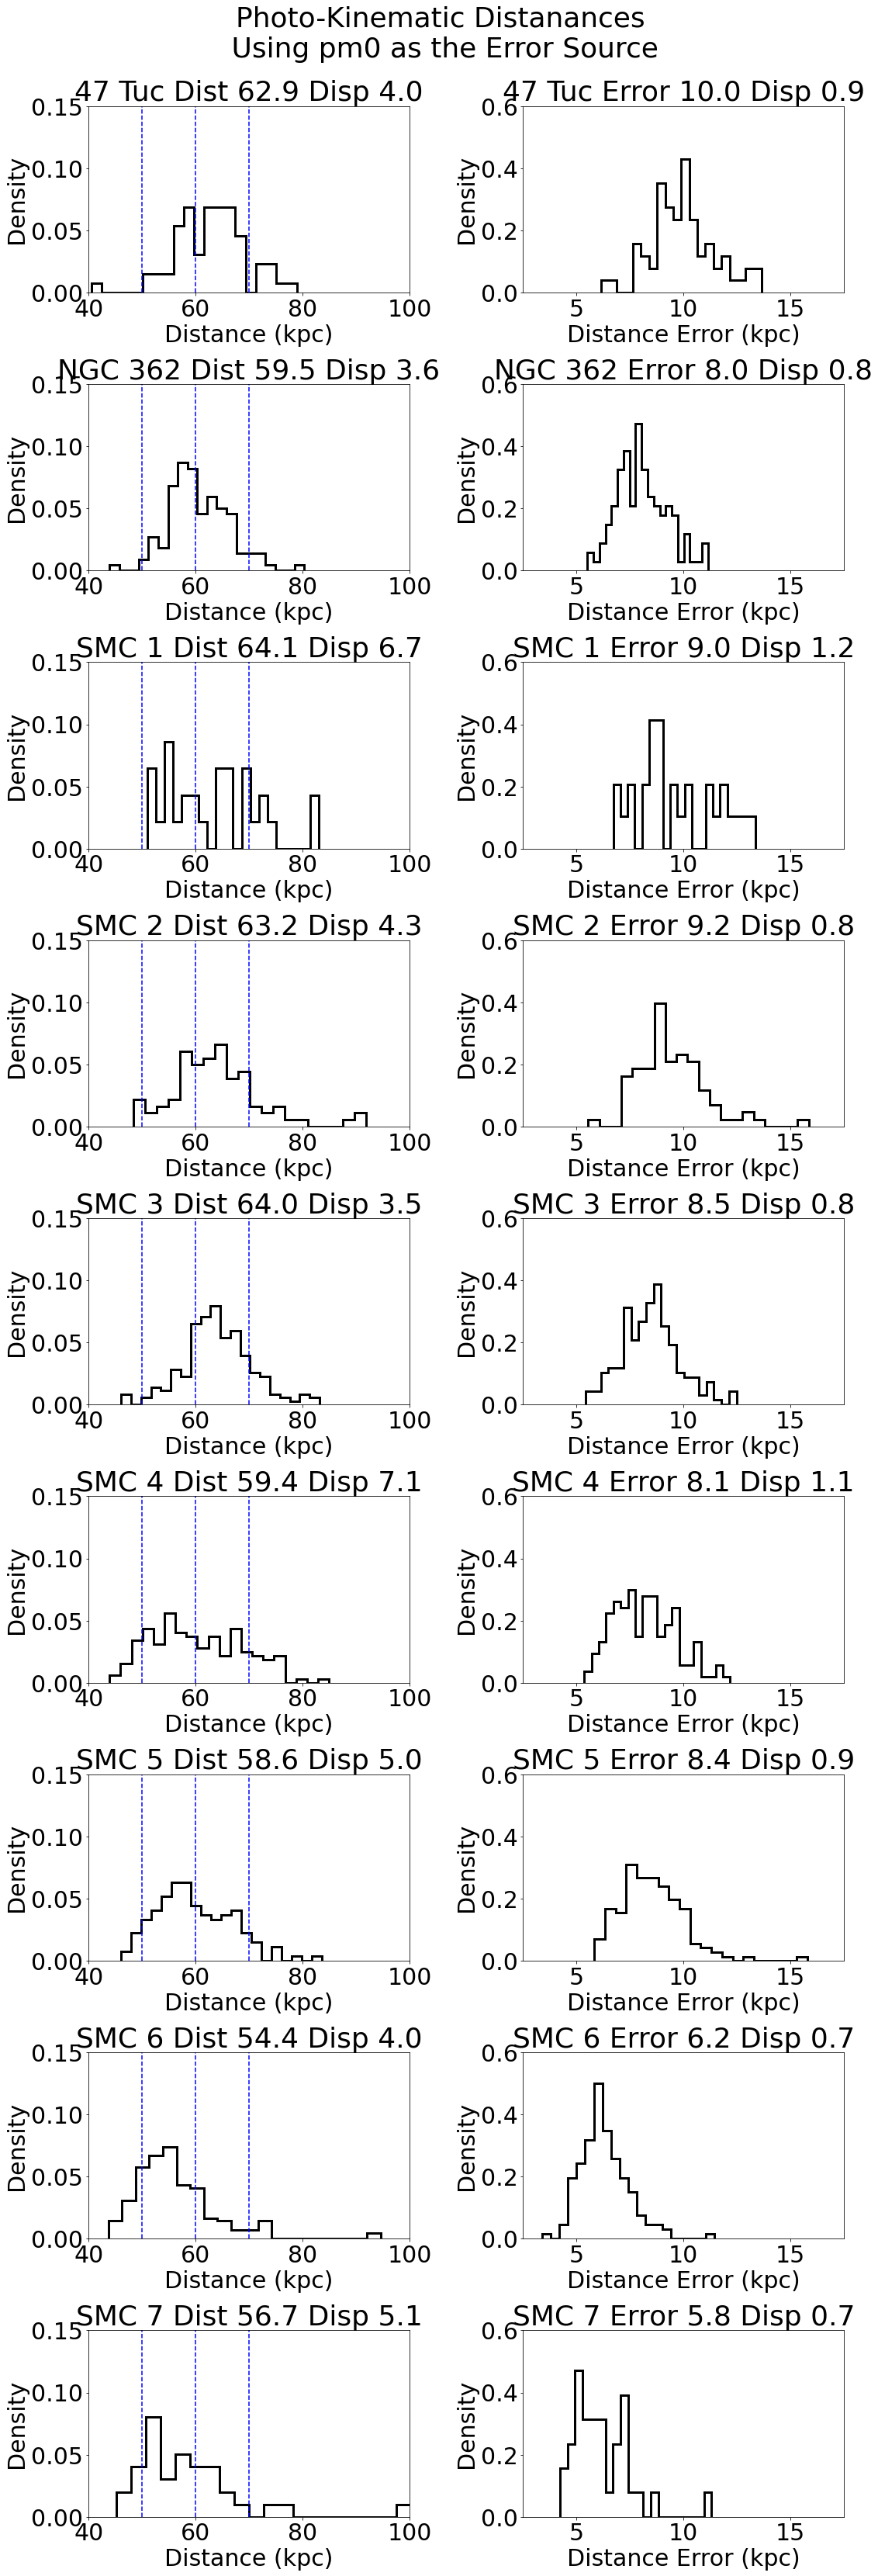

In [34]:
distance_kpdist = [np.median(tuc47_kpdistpm0,1),np.median(n362_kpdistpm0,1),np.median(smc1_kpdistpm0,1),
                 np.median(smc2_kpdistpm0,1),np.median(smc3_kpdistpm0,1),np.median(smc4_kpdistpm0,1),
                 np.median(smc5_kpdistpm0,1),np.median(smc6_kpdistpm0,1),np.median(smc7_kpdistpm0,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdistpm0),util.mad(n362_kpdistpm0),util.mad(smc1_kpdistpm0),
                      util.mad(smc2_kpdistpm0),util.mad(smc3_kpdistpm0),util.mad(smc4_kpdistpm0),
                      util.mad(smc5_kpdistpm0),util.mad(smc6_kpdistpm0),util.mad(smc7_kpdistpm0)]

distance_kpdist_err = [tuc47_kpdistpm0_errs,n362_kpdistpm0_errs,smc1_kpdistpm0_errs,smc2_kpdistpm0_errs,
                       smc3_kpdistpm0_errs,smc4_kpdistpm0_errs,smc5_kpdistpm0_errs,smc6_kpdistpm0_errs,
                       smc7_kpdistpm0_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdistpm0_errs),util.mad(n362_kpdistpm0_errs),
                            util.mad(smc1_kpdistpm0_errs),util.mad(smc2_kpdistpm0_errs),
                            util.mad(smc3_kpdistpm0_errs),util.mad(smc4_kpdistpm0_errs),
                            util.mad(smc5_kpdistpm0_errs),util.mad(smc6_kpdistpm0_errs),
                            util.mad(smc7_kpdistpm0_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.15)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=0.6)
    ax[i][1].set_xlim(2.5,17.5)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    
#     ax[i][1].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
#                                                         util.mad(distance_kpdist[i])))
    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                            util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances\n Using pm0 as the Error Source',y=1.025)
plt.tight_layout(pad=0.5)

# plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

<font size='45'>
    <b>
        Photo-Kinematic Distance d0 Error
    </b>
</font>

In [35]:
tuc47_kpdistd0 = []
tuc47_kpdistd0_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[0]/1000.,dist_edr3_meds_err[0]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[0]),mu)
    
    tuc47_kpdistd0.append(dd0)
    tuc47_kpdistd0_errs.append(util.mad(dd0))
    
n362_kpdistd0 = []
n362_kpdistd0_errs = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[1]/1000.,dist_edr3_meds_err[1]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[1]),mu)

    n362_kpdistd0.append(dd0)
    n362_kpdistd0_errs.append(util.mad(dd0))
    
smc1_kpdistd0 = []
smc1_kpdistd0_errs = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[2]/1000.,dist_edr3_meds_err[2]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[2]),mu)
    
    smc1_kpdistd0.append(dd0)
    smc1_kpdistd0_errs.append(util.mad(dd0))
    smc1_kpdistpm.append(dpm)
    smc1_kpdistpm_errs.append(util.mad(dpm))
    
smc2_kpdistd0 = []
smc2_kpdistd0_errs = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[3]/1000.,dist_edr3_meds_err[3]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[3]),mu)
    
    smc2_kpdistd0.append(dd0)
    smc2_kpdistd0_errs.append(util.mad(dd0))
    
smc3_kpdistd0 = []
smc3_kpdistd0_errs = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[4]/1000.,dist_edr3_meds_err[4]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[4]),mu)
    
    smc3_kpdistd0.append(dd0)
    smc3_kpdistd0_errs.append(util.mad(dd0))
    
smc4_kpdistd0 = []
smc4_kpdistd0_errs = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[5]/1000.,dist_edr3_meds_err[5]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[5]),mu)
    
    smc4_kpdistd0.append(dd0)
    smc4_kpdistd0_errs.append(util.mad(dd0))
    
smc5_kpdistd0 = []
smc5_kpdistd0_errs = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[6]/1000.,dist_edr3_meds_err[6]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[6]),mu)
    
    smc5_kpdistd0.append(dd0)
    smc5_kpdistd0_errs.append(util.mad(dd0))
    
smc6_kpdistd0 = []
smc6_kpdistd0_errs = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[7]/1000.,dist_edr3_meds_err[7]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[7]),mu)
    
    smc6_kpdistd0.append(dd0)
    smc6_kpdistd0_errs.append(util.mad(dd0))
    
smc7_kpdistd0 = []
smc7_kpdistd0_errs = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    
    # Gaussian Noise
    d0 = np.random.normal(dist_edr3_meds[8]/1000.,dist_edr3_meds_err[8]/1000.,100)
    
    # Calculate Distances with Errors
    dd0 = d0*np.divide(np.median(rc_mu_fields[8]),mu)
    
    smc7_kpdistd0.append(dd0)
    smc7_kpdistd0_errs.append(util.mad(dd0))

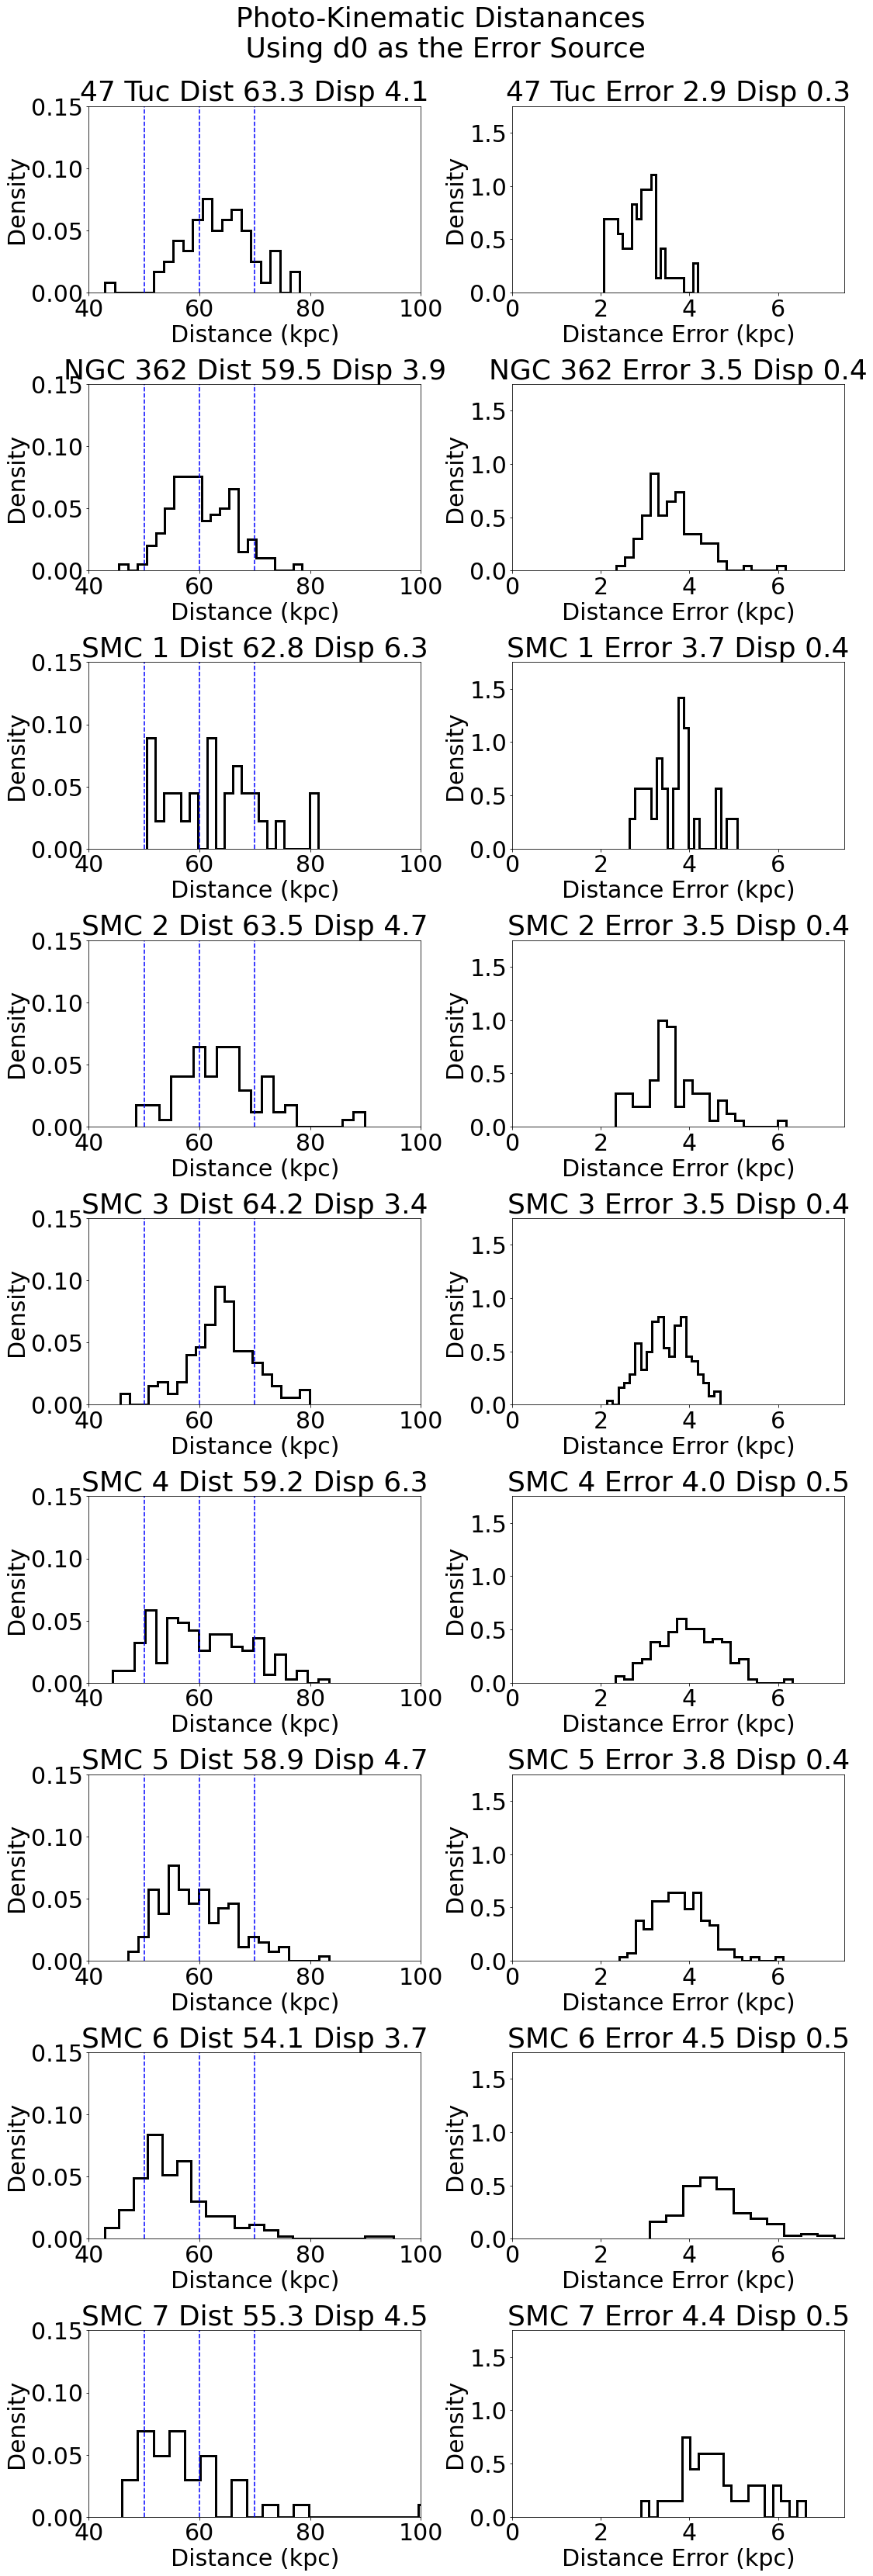

In [36]:
distance_kpdist = [np.median(tuc47_kpdistd0,1),np.median(n362_kpdistd0,1),np.median(smc1_kpdistd0,1),
                 np.median(smc2_kpdistd0,1),np.median(smc3_kpdistd0,1),np.median(smc4_kpdistd0,1),
                 np.median(smc5_kpdistd0,1),np.median(smc6_kpdistd0,1),np.median(smc7_kpdistd0,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdistd0),util.mad(n362_kpdistd0),util.mad(smc1_kpdistd0),
                      util.mad(smc2_kpdistd0),util.mad(smc3_kpdistd0),util.mad(smc4_kpdistd0),
                      util.mad(smc5_kpdistd0),util.mad(smc6_kpdistd0),util.mad(smc7_kpdistd0)]

distance_kpdist_err = [tuc47_kpdistd0_errs,n362_kpdistd0_errs,smc1_kpdistd0_errs,smc2_kpdistd0_errs,
                       smc3_kpdistd0_errs,smc4_kpdistd0_errs,smc5_kpdistd0_errs,smc6_kpdistd0_errs,
                       smc7_kpdistd0_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdistd0_errs),util.mad(n362_kpdistd0_errs),
                            util.mad(smc1_kpdistd0_errs),util.mad(smc2_kpdistd0_errs),
                            util.mad(smc3_kpdistd0_errs),util.mad(smc4_kpdistd0_errs),
                            util.mad(smc5_kpdistd0_errs),util.mad(smc6_kpdistd0_errs),
                            util.mad(smc7_kpdistd0_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.15)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=1.75)
    ax[i][1].set_xlim(0.,7.5)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    
#     ax[i][1].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
#                                                         util.mad(distance_kpdist[i])))
    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                            util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances\n Using d0 as the Error Source',y=1.025)
plt.tight_layout(pad=0.5)

# plt.savefig('photokinematic_distances.pdf',bbox_inches='tight')
plt.show()

<font size='45'>
    <b>
        Photo-Kinematic Distance 27 km/s Tan Dispersion &amp; PM
    </b>
</font>

In [37]:
tuc47_kpdist27pm = []
tuc47_kpdist27pm_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[0]/1000.*np.median(rc_mu_fields[0])
    tanv_err = 27 #km/s
    
    tuc47_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    tuc47_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))

In [38]:
tuc47_kpdist27pm = []
tuc47_kpdist27pm_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[0]/1000.*np.median(rc_mu_fields[0])
    tanv_err = 27 #km/s  
    tuc47_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    tuc47_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
n362_kpdist27pm = []
n362_kpdist27pm_errs = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[1]/1000.*np.median(rc_mu_fields[1])
    tanv_err = 27 #km/s
    n362_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    n362_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc1_kpdist27pm = []
smc1_kpdist27pm_errs = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[2]/1000.*np.median(rc_mu_fields[2])
    tanv_err = 27 #km/s
    smc1_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc1_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc2_kpdist27pm = []
smc2_kpdist27pm_errs = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[3]/1000.*np.median(rc_mu_fields[3])
    tanv_err = 27 #km/s
    smc2_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc2_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc3_kpdist27pm = []
smc3_kpdist27pm_errs = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[4]/1000.*np.median(rc_mu_fields[4])
    tanv_err = 27 #km/s
    smc3_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc3_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc4_kpdist27pm = []
smc4_kpdist27pm_errs = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[5]/1000.*np.median(rc_mu_fields[5])
    tanv_err = 27 #km/s
    smc4_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc4_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc5_kpdist27pm = []
smc5_kpdist27pm_errs = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[6]/1000.*np.median(rc_mu_fields[6])
    tanv_err = 27 #km/s
    smc5_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc5_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc6_kpdist27pm = []
smc6_kpdist27pm_errs = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[7]/1000.*np.median(rc_mu_fields[7])
    tanv_err = 27 #km/s
    smc6_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc6_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))
    
smc7_kpdist27pm = []
smc7_kpdist27pm_errs = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[8]/1000.*np.median(rc_mu_fields[8])
    tanv_err = 27 #km/s
    smc7_kpdist27pm.append(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100)))
    smc7_kpdist27pm_errs.append(util.mad(np.random.normal(tanv,27,100)/(4.74*np.random.normal(mu,mu_err,100))))

In [39]:
np.median(smc7_kpdist27,1)

array([ 52.89504665,  51.25278862,  58.28897961,  72.64149492,
        79.13423141,  63.89298674,  51.73443298,  58.70670898,
       101.66723209,  53.91718854,  49.30524639,  67.4727899 ,
        55.88635195,  46.0405836 ,  58.90922071,  50.29129535,
        64.22043328,  54.6020405 ,  52.08637664,  54.63778972,
        50.15741574,  46.39278376,  48.1004539 ,  50.15594319,
        64.2197552 ,  58.42948696,  51.39796953,  52.21740801,
        55.49298594,  66.12236457,  57.01326508,  61.7871755 ,
        65.63697945,  52.04054189,  60.10999931,  54.7740361 ])

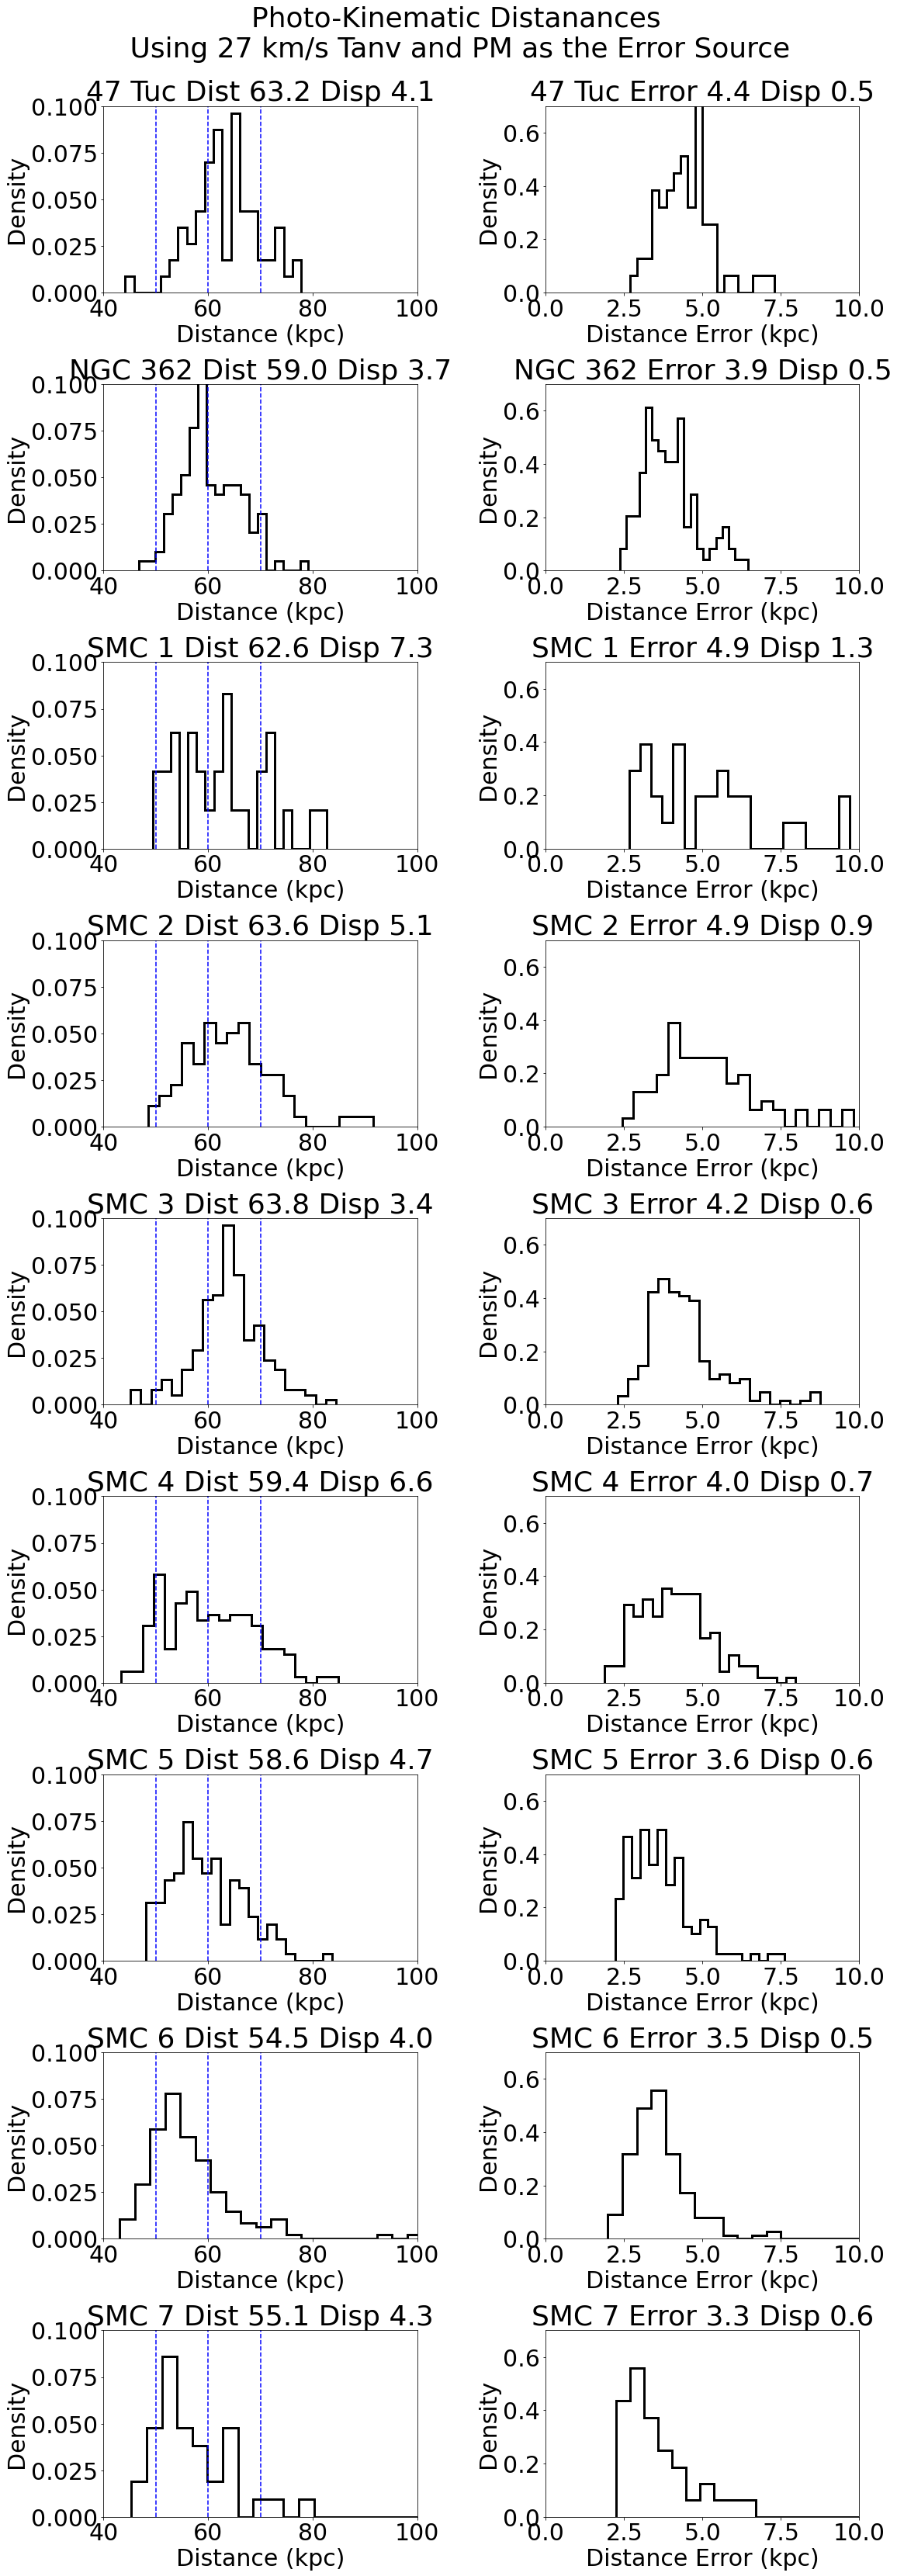

In [40]:
distance_kpdist = [np.median(tuc47_kpdist27pm,1),np.median(n362_kpdist27pm,1),np.median(smc1_kpdist27pm,1),
                 np.median(smc2_kpdist27pm,1),np.median(smc3_kpdist27pm,1),np.median(smc4_kpdist27pm,1),
                 np.median(smc5_kpdist27pm,1),np.median(smc6_kpdist27pm,1),np.median(smc7_kpdist27pm,1)]

distance_kpdist_disp = [util.mad(tuc47_kpdist27pm),util.mad(n362_kpdist27pm),util.mad(smc1_kpdist27pm),
                      util.mad(smc2_kpdist27pm),util.mad(smc3_kpdist27pm),util.mad(smc4_kpdist27pm),
                      util.mad(smc5_kpdist27pm),util.mad(smc6_kpdist27pm),util.mad(smc7_kpdist27pm)]

distance_kpdist_err = [tuc47_kpdist27pm_errs,n362_kpdist27pm_errs,smc1_kpdist27pm_errs,smc2_kpdist27pm_errs,
                       smc3_kpdist27pm_errs,smc4_kpdist27pm_errs,smc5_kpdist27pm_errs,smc6_kpdist27pm_errs,
                       smc7_kpdist27pm_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdist27pm_errs),util.mad(n362_kpdist27pm_errs),
                            util.mad(smc1_kpdist27pm_errs),util.mad(smc2_kpdist27pm_errs),
                            util.mad(smc3_kpdist27pm_errs),util.mad(smc4_kpdist27pm_errs),
                            util.mad(smc5_kpdist27pm_errs),util.mad(smc6_kpdist27pm_errs),
                            util.mad(smc7_kpdist27pm_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.1)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                        util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=0.7)
    ax[i][1].set_xlim(0.,10.)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    
#     ax[i][1].set_title(r'{} Dist {:.1f} +/- {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
#                                                         util.mad(distance_kpdist[i])))
    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                            util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances\n Using 27 km/s Tanv and PM as the Error Source',y=1.025)
plt.tight_layout(pad=0.5)

plt.savefig('photokinematic_distances27pm.pdf',bbox_inches='tight')
plt.show()

In [41]:
### 47 Tuc
smc47field = []
smc47mads = []
for i in range(len(np.squeeze(tuc47_ind))):
    smc47field.append('47TUC')
    smc47mads.append(util.mad(tuc47_kpdist27pm[i]))

tsmc47 = Table()
col_id = Column(np.asarray(smc[tuc47_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc47field),name='FIELD')
col_distance = Column(np.median(tuc47_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc47mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(tuc47_kpdist27pm),name='DISTANCE_DIST')

tsmc47.add_column(col_id)
tsmc47.add_column(col_field)
tsmc47.add_column(col_distance)
tsmc47.add_column(col_dev)
tsmc47.add_column(col_dist)

### NGC 362
smc362field = []
smc362mads = []
for i in range(len(np.squeeze(n362_ind))):
    smc362field.append('N362')
    smc362mads.append(util.mad(n362_kpdist27pm[i]))

tsmc362 = Table()
col_id = Column(np.asarray(smc[n362_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc362field),name='FIELD')
col_distance = Column(np.median(n362_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc362mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(n362_kpdist27pm),name='DISTANCE_DIST')

tsmc362.add_column(col_id)
tsmc362.add_column(col_field)
tsmc362.add_column(col_distance)
tsmc362.add_column(col_dev)
tsmc362.add_column(col_dist)

### SMC 1
smc1field = []
smc1mads = []
for i in range(len(np.squeeze(smc1_ind))):
    smc1field.append('SMC1')
    smc1mads.append(util.mad(smc1_kpdist27pm[i]))

tsmc1 = Table()
col_id = Column(np.asarray(smc[smc1_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc1field),name='FIELD')
col_distance = Column(np.median(smc1_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc1mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc1_kpdist27pm),name='DISTANCE_DIST')

tsmc1.add_column(col_id)
tsmc1.add_column(col_field)
tsmc1.add_column(col_distance)
tsmc1.add_column(col_dev)
tsmc1.add_column(col_dist)

### SMC 2
smc2field = []
smc2mads = []
for i in range(len(np.squeeze(smc2_ind))):
    smc2field.append('SMC2')
    smc2mads.append(util.mad(smc2_kpdist27pm[i]))

tsmc2 = Table()
col_id = Column(np.asarray(smc[smc2_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc2field),name='FIELD')
col_distance = Column(np.median(smc2_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc2mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc2_kpdist27pm),name='DISTANCE_DIST')

tsmc2.add_column(col_id)
tsmc2.add_column(col_field)
tsmc2.add_column(col_distance)
tsmc2.add_column(col_dev)
tsmc2.add_column(col_dist)

### SMC 3
smc3field = []
smc3mads = []
for i in range(len(np.squeeze(smc3_ind))):
    smc3field.append('SMC3')
    smc3mads.append(util.mad(smc3_kpdist27pm[i]))
    
tsmc3 = Table()
col_id = Column(np.asarray(smc[smc3_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc3field),name='FIELD')
col_distance = Column(np.median(smc3_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc3mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc3_kpdist27pm),name='DISTANCE_DIST')

tsmc3.add_column(col_id)
tsmc3.add_column(col_field)
tsmc3.add_column(col_distance)
tsmc3.add_column(col_dev)
tsmc3.add_column(col_dist)

### SMC 4
smc4field = []
smc4mads = []
for i in range(len(np.squeeze(smc4_ind))):
    smc4field.append('SMC4')
    smc4mads.append(util.mad(smc4_kpdist27pm[i]))
    
tsmc4 = Table()
col_id = Column(np.asarray(smc[smc4_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc4field),name='FIELD')
col_distance = Column(np.median(smc4_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc4mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc4_kpdist27pm),name='DISTANCE_DIST')

tsmc4.add_column(col_id)
tsmc4.add_column(col_field)
tsmc4.add_column(col_distance)
tsmc4.add_column(col_dev)
tsmc4.add_column(col_dist)

### SMC 5
smc5field = []
smc5mads = []
for i in range(len(np.squeeze(smc5_ind))):
    smc5field.append('SMC5')
    smc5mads.append(util.mad(smc5_kpdist27pm[i]))

tsmc5 = Table()
col_id = Column(np.asarray(smc[smc5_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc5field),name='FIELD')
col_distance = Column(np.median(smc5_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc5mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc5_kpdist27pm),name='DISTANCE_DIST')

tsmc5.add_column(col_id)
tsmc5.add_column(col_field)
tsmc5.add_column(col_distance)
tsmc5.add_column(col_dev)
tsmc5.add_column(col_dist)

### SMC 6
smc6field = []
smc6mads = []
for i in range(len(np.squeeze(smc6_ind))):
    smc6field.append('SMC6')
    smc6mads.append(util.mad(smc6_kpdist27pm[i]))

tsmc6 = Table()
col_id = Column(np.asarray(smc[smc6_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc6field),name='FIELD')
col_distance = Column(np.median(smc6_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc6mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc6_kpdist27pm),name='DISTANCE_DIST')

tsmc6.add_column(col_id)
tsmc6.add_column(col_field)
tsmc6.add_column(col_distance)
tsmc6.add_column(col_dev)
tsmc6.add_column(col_dist)

### SMC 7
smc7field = []
smc7mads = []
for i in range(len(np.squeeze(smc7_ind))):
    smc7field.append('SMC7')
    smc7mads.append(util.mad(smc7_kpdist27pm[i]))

tsmc7 = Table()
col_id = Column(np.asarray(smc[smc7_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc7field),name='FIELD')
col_distance = Column(np.median(smc7_kpdist27pm,1),name='DISTANCE')
col_dev = Column(np.asarray(smc7mads),name='DISTANCE_ERR')
col_dist = Column(np.asarray(smc7_kpdist27pm),name='DISTANCE_DIST')

tsmc7.add_column(col_id)
tsmc7.add_column(col_field)
tsmc7.add_column(col_distance)
tsmc7.add_column(col_dev)
tsmc7.add_column(col_dist)

### order matches original smc file 
distance_table = vstack([tsmc3,tsmc362,tsmc5,tsmc47,tsmc4,tsmc6,tsmc1,tsmc2,tsmc7])

# distance_table.write('smc_photokinematic_distances27pm.fits')#,format='fits',overwrite=True)

In [42]:
calc_distance27pm = fits.getdata('smc_photokinematic_distances27pm.fits',0)
calc_distance27pm.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'FIELD'; format = '5A'
    name = 'DISTANCE'; format = 'D'
    name = 'DISTANCE_ERR'; format = 'D'
    name = 'DISTANCE_DIST'; format = '100D'; dim = '(100)'
)

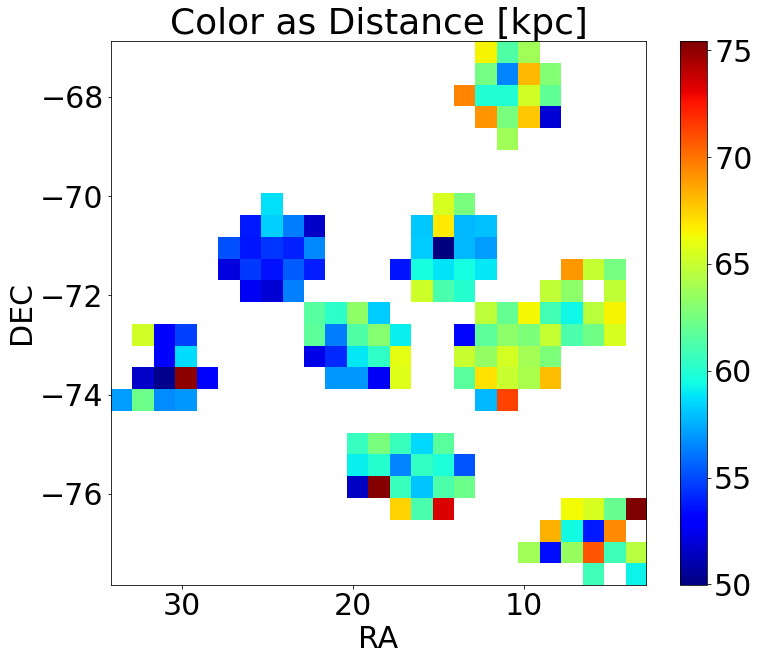

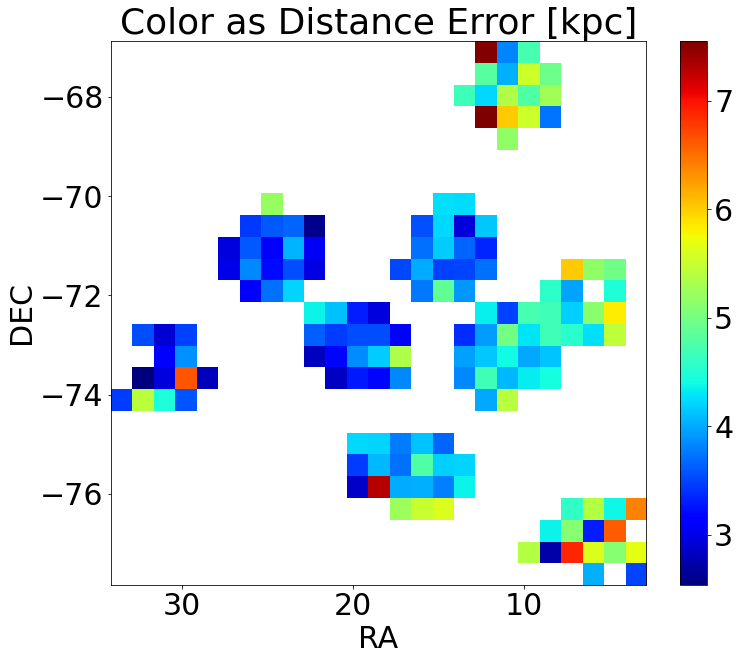

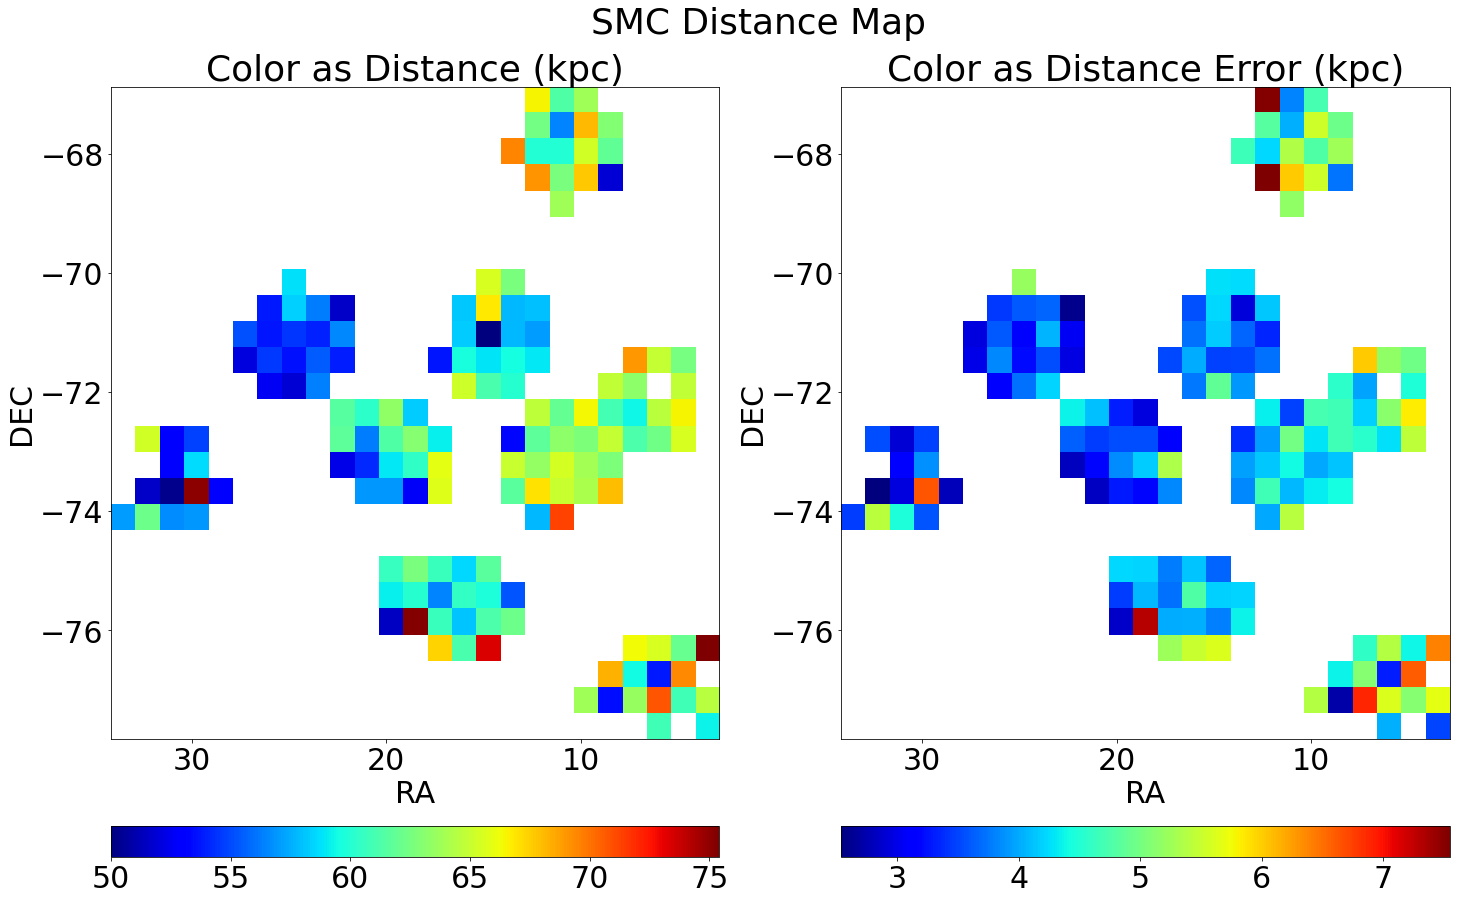

In [43]:
from scipy.stats import binned_statistic_2d
distmed = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance27pm['DISTANCE'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(distmed.statistic.T, origin='lower',
           extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map27pm.pdf',bbox_inches='tight')
plt.show()

#### 
disterr = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance27pm['DISTANCE_ERR'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(disterr.statistic.T, origin='lower',
           extent=[disterr.x_edge[0],disterr.x_edge[-1],disterr.y_edge[0],disterr.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance Error [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map27pm_err.pdf',bbox_inches='tight')
plt.show()

#####
fig,ax = plt.subplots(1,2,figsize=[24,16])
im0 = ax[0].imshow(distmed.statistic.T, origin='lower',
                   extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],
                   aspect='auto',interpolation='nearest', cmap='jet')

im1 = ax[1].imshow(disterr.statistic.T, origin='lower',
                   extent=[disterr.x_edge[0],disterr.x_edge[-1],disterr.y_edge[0],disterr.y_edge[-1]],
                   aspect='auto',interpolation='nearest', cmap='jet')

ax[0].set_title(r'Color as Distance (kpc)')#,y=-0.19)
ax[1].set_title(r'Color as Distance Error (kpc)')#,y=-0.19)

for i in [0,1]:
    ax[i].invert_xaxis()
    ax[i].set_xlabel(r'RA')
    ax[i].set_ylabel(r'DEC')
    
fig.colorbar(im0,ax=ax[0],orientation='horizontal',pad=0.1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal',pad=0.1)

fig.suptitle(r'SMC Distance Map',y=0.95)

plt.savefig('distancemap27pm.pdf',bbox_inches='tight')
plt.show()

<font size='15'>
    <b>
        Same As Above Using Error Propagation Instead of MC
    </b>
</font>

In [44]:
tuc47_kpdist27pmEP = []
tuc47_kpdist27pmEP_errs = []
for i in np.squeeze(tuc47_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[0]/1000.*np.median(rc_mu_fields[0])
    tanv_err = 27 #km/s
    
    tuc47_kpdist27pmEP.append(tanv/(4.74*mu))
    tuc47_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
n362_kpdist27pmEP = []
n362_kpdist27pmEP_errs = []
for i in np.squeeze(n362_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[1]/1000.*np.median(rc_mu_fields[1])
    tanv_err = 27 #km/s
    
    n362_kpdist27pmEP.append(tanv/(4.74*mu))
    n362_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc1_kpdist27pmEP = []
smc1_kpdist27pmEP_errs = []
for i in np.squeeze(smc1_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[2]/1000.*np.median(rc_mu_fields[2])
    tanv_err = 27 #km/s
    
    smc1_kpdist27pmEP.append(tanv/(4.74*mu))
    smc1_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc2_kpdist27pmEP = []
smc2_kpdist27pmEP_errs = []
for i in np.squeeze(smc2_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[3]/1000.*np.median(rc_mu_fields[3])
    tanv_err = 27 #km/s
    
    smc2_kpdist27pmEP.append(tanv/(4.74*mu))
    smc2_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc3_kpdist27pmEP = []
smc3_kpdist27pmEP_errs = []
for i in np.squeeze(smc3_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[4]/1000.*np.median(rc_mu_fields[4])
    tanv_err = 27 #km/s
    
    smc3_kpdist27pmEP.append(tanv/(4.74*mu))
    smc3_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc4_kpdist27pmEP = []
smc4_kpdist27pmEP_errs = []
for i in np.squeeze(smc4_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[5]/1000.*np.median(rc_mu_fields[5])
    tanv_err = 27 #km/s
    
    smc4_kpdist27pmEP.append(tanv/(4.74*mu))
    smc4_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc5_kpdist27pmEP = []
smc5_kpdist27pmEP_errs = []
for i in np.squeeze(smc5_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[6]/1000.*np.median(rc_mu_fields[6])
    tanv_err = 27 #km/s
    
    smc5_kpdist27pmEP.append(tanv/(4.74*mu))
    smc5_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc6_kpdist27pmEP = []
smc6_kpdist27pmEP_errs = []
for i in np.squeeze(smc6_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[7]/1000.*np.median(rc_mu_fields[7])
    tanv_err = 27 #km/s
    
    smc6_kpdist27pmEP.append(tanv/(4.74*mu))
    smc6_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))
    
smc7_kpdist27pmEP = []
smc7_kpdist27pmEP_errs = []
for i in np.squeeze(smc7_ind):
    mu = np.sqrt(smc['GAIA_PMRA'][i]**2+smc['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc['GAIA_PMRA_ERROR'][i]**2+smc['GAIA_PMDEC_ERROR'][i]**2)
    tanv = 4.74*dist_edr3_meds[8]/1000.*np.median(rc_mu_fields[8])
    tanv_err = 27 #km/s
    
    smc7_kpdist27pmEP.append(tanv/(4.74*mu))
    smc7_kpdist27pmEP_errs.append(np.sqrt(tanv_err**2+(tanv*mu_err/mu)**2)/(4.74*mu))

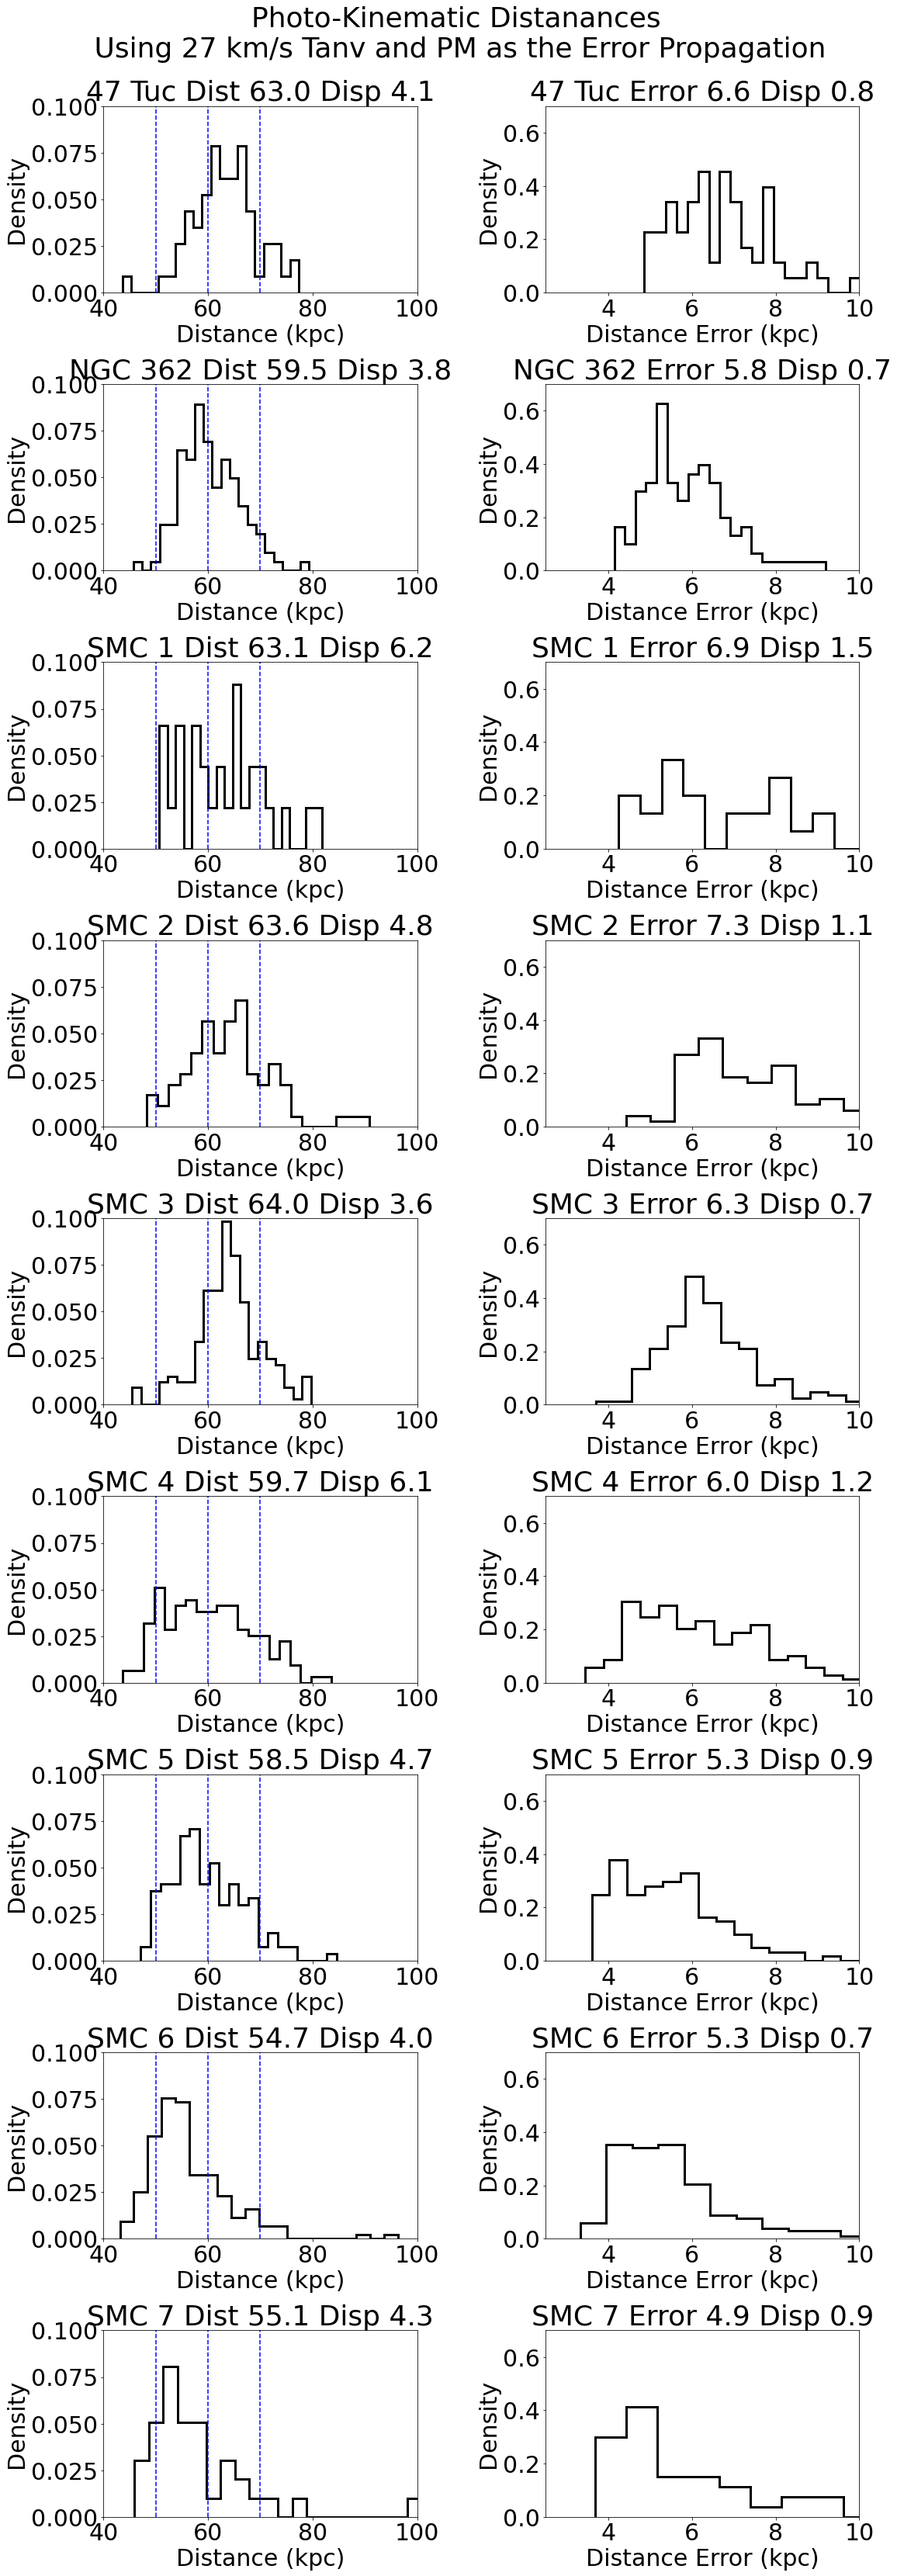

In [45]:
distance_kpdist = [tuc47_kpdist27pmEP,n362_kpdist27pmEP,smc1_kpdist27pmEP,smc2_kpdist27pmEP,smc3_kpdist27pmEP,
                   smc4_kpdist27pmEP,smc5_kpdist27pmEP,smc6_kpdist27pmEP,smc7_kpdist27pmEP]

distance_kpdist_disp = [util.mad(tuc47_kpdist27pmEP),util.mad(n362_kpdist27pmEP),util.mad(smc1_kpdist27pmEP),
                      util.mad(smc2_kpdist27pmEP),util.mad(smc3_kpdist27pmEP),util.mad(smc4_kpdist27pmEP),
                      util.mad(smc5_kpdist27pmEP),util.mad(smc6_kpdist27pmEP),util.mad(smc7_kpdist27pmEP)]

distance_kpdist_err = [tuc47_kpdist27pmEP_errs,n362_kpdist27pmEP_errs,smc1_kpdist27pmEP_errs,
                       smc2_kpdist27pmEP_errs,smc3_kpdist27pmEP_errs,smc4_kpdist27pmEP_errs,
                       smc5_kpdist27pmEP_errs,smc6_kpdist27pmEP_errs,smc7_kpdist27pmEP_errs]

distance_kpdist_err_disp = [util.mad(tuc47_kpdist27pmEP_errs),util.mad(n362_kpdist27pmEP_errs),
                            util.mad(smc1_kpdist27pmEP_errs),util.mad(smc2_kpdist27pmEP_errs),
                            util.mad(smc3_kpdist27pmEP_errs),util.mad(smc4_kpdist27pmEP_errs),
                            util.mad(smc5_kpdist27pmEP_errs),util.mad(smc6_kpdist27pmEP_errs),
                            util.mad(smc7_kpdist27pmEP_errs)]

distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(distance_kpdist[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][0].set_ylim(top=0.1)
    ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'Distance (kpc)')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} Dist {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist[i]),
                                                            util.mad(distance_kpdist[i])))
    
    ax[i][0].axvline(50,ls='--',c='b')
    ax[i][0].axvline(60,ls='--',c='b')
    ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(distance_kpdist_err[i],density=True,bins=20,histtype='step',lw=3.0,color='k')
    
    ax[i][1].set_ylim(top=0.7)
    ax[i][1].set_xlim(2.5,10.)
    ax[i][1].set_xlabel(r'Distance Error (kpc)')
    ax[i][1].set_ylabel(r'Density')

    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(distance_label[i],np.median(distance_kpdist_err[i]),
                                                             util.mad(distance_kpdist_err[i])))

plt.suptitle('Photo-Kinematic Distanances\n Using 27 km/s Tanv and PM as the Error Propagation',y=1.025)
plt.tight_layout(pad=0.5)

plt.savefig('photokinematic_distances27pmEP.pdf',bbox_inches='tight')
plt.show()

In [46]:
### 47 Tuc
smc47field = []
for i in range(len(np.squeeze(tuc47_ind))):
    smc47field.append('47TUC')

tsmc47 = Table()
col_id = Column(np.asarray(smc[tuc47_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc47field),name='FIELD')
col_distance = Column(tuc47_kpdist27pmEP,name='DISTANCE')
col_dev = Column(tuc47_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc47.add_column(col_id)
tsmc47.add_column(col_field)
tsmc47.add_column(col_distance)
tsmc47.add_column(col_dev)

### NGC 362
smc362field = []
for i in range(len(np.squeeze(n362_ind))):
    smc362field.append('N362')

tsmc362 = Table()
col_id = Column(np.asarray(smc[n362_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc362field),name='FIELD')
col_distance = Column(n362_kpdist27pmEP,name='DISTANCE')
col_dev = Column(n362_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc362.add_column(col_id)
tsmc362.add_column(col_field)
tsmc362.add_column(col_distance)
tsmc362.add_column(col_dev)

### SMC 1
smc1field = []
for i in range(len(np.squeeze(smc1_ind))):
    smc1field.append('SMC1')

tsmc1 = Table()
col_id = Column(np.asarray(smc[smc1_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc1field),name='FIELD')
col_distance = Column(smc1_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc1_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc1.add_column(col_id)
tsmc1.add_column(col_field)
tsmc1.add_column(col_distance)
tsmc1.add_column(col_dev)

### SMC 2
smc2field = []
for i in range(len(np.squeeze(smc2_ind))):
    smc2field.append('SMC2')

tsmc2 = Table()
col_id = Column(np.asarray(smc[smc2_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc2field),name='FIELD')
col_distance = Column(smc2_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc2_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc2.add_column(col_id)
tsmc2.add_column(col_field)
tsmc2.add_column(col_distance)
tsmc2.add_column(col_dev)

### SMC 3
smc3field = []
for i in range(len(np.squeeze(smc3_ind))):
    smc3field.append('SMC3')
    
tsmc3 = Table()
col_id = Column(np.asarray(smc[smc3_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc3field),name='FIELD')
col_distance = Column(smc3_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc3_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc3.add_column(col_id)
tsmc3.add_column(col_field)
tsmc3.add_column(col_distance)
tsmc3.add_column(col_dev)

### SMC 4
smc4field = []
for i in range(len(np.squeeze(smc4_ind))):
    smc4field.append('SMC4')
    
tsmc4 = Table()
col_id = Column(np.asarray(smc[smc4_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc4field),name='FIELD')
col_distance = Column(smc4_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc4_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc4.add_column(col_id)
tsmc4.add_column(col_field)
tsmc4.add_column(col_distance)
tsmc4.add_column(col_dev)

### SMC 5
smc5field = []
for i in range(len(np.squeeze(smc5_ind))):
    smc5field.append('SMC5')

tsmc5 = Table()
col_id = Column(np.asarray(smc[smc5_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc5field),name='FIELD')
col_distance = Column(smc5_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc5_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc5.add_column(col_id)
tsmc5.add_column(col_field)
tsmc5.add_column(col_distance)
tsmc5.add_column(col_dev)

### SMC 6
smc6field = []
for i in range(len(np.squeeze(smc6_ind))):
    smc6field.append('SMC6')

tsmc6 = Table()
col_id = Column(np.asarray(smc[smc6_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc6field),name='FIELD')
col_distance = Column(smc6_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc6_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc6.add_column(col_id)
tsmc6.add_column(col_field)
tsmc6.add_column(col_distance)
tsmc6.add_column(col_dev)

### SMC 7
smc7field = []
for i in range(len(np.squeeze(smc7_ind))):
    smc7field.append('SMC7')

tsmc7 = Table()
col_id = Column(np.asarray(smc[smc7_ind]['APOGEE_ID']),name='APOGEE_ID')
col_field = Column(np.asarray(smc7field),name='FIELD')
col_distance = Column(smc7_kpdist27pmEP,name='DISTANCE')
col_dev = Column(smc7_kpdist27pmEP_errs,name='DISTANCE_ERR')

tsmc7.add_column(col_id)
tsmc7.add_column(col_field)
tsmc7.add_column(col_distance)
tsmc7.add_column(col_dev)

### order matches original smc file 
distance_table = vstack([tsmc3,tsmc362,tsmc5,tsmc47,tsmc4,tsmc6,tsmc1,tsmc2,tsmc7])

# distance_table.write('smc_photokinematic_distances27pmEP.fits')#,format='fits',overwrite=True)

In [47]:
calc_distance27pmEP = fits.getdata('smc_photokinematic_distances27pmEP.fits',0)
calc_distance27pmEP.columns

ColDefs(
    name = 'APOGEE_ID'; format = '18A'
    name = 'FIELD'; format = '5A'
    name = 'DISTANCE'; format = 'D'
    name = 'DISTANCE_ERR'; format = 'D'
)

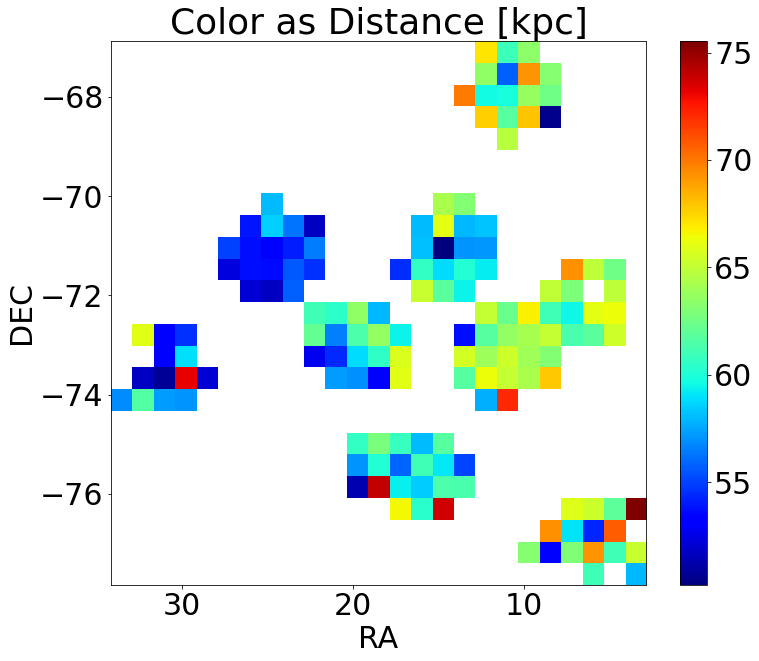

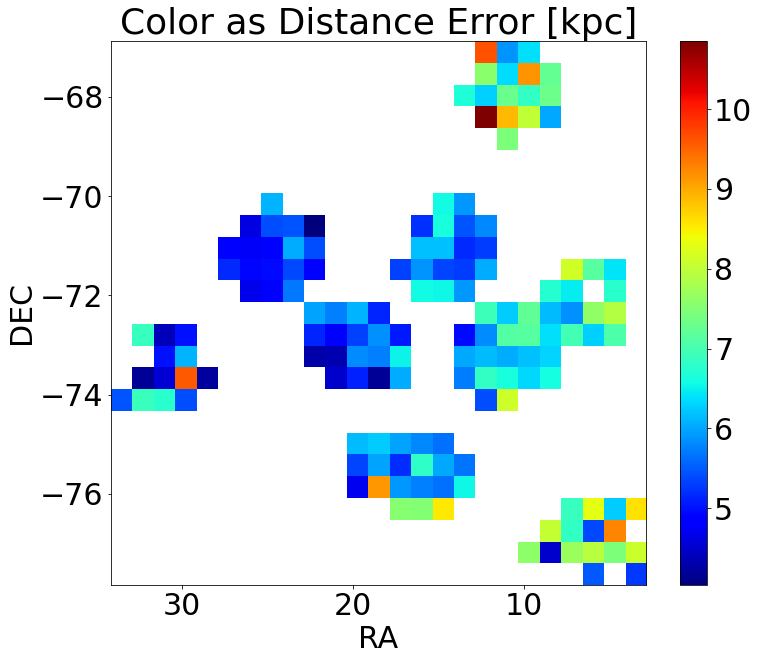

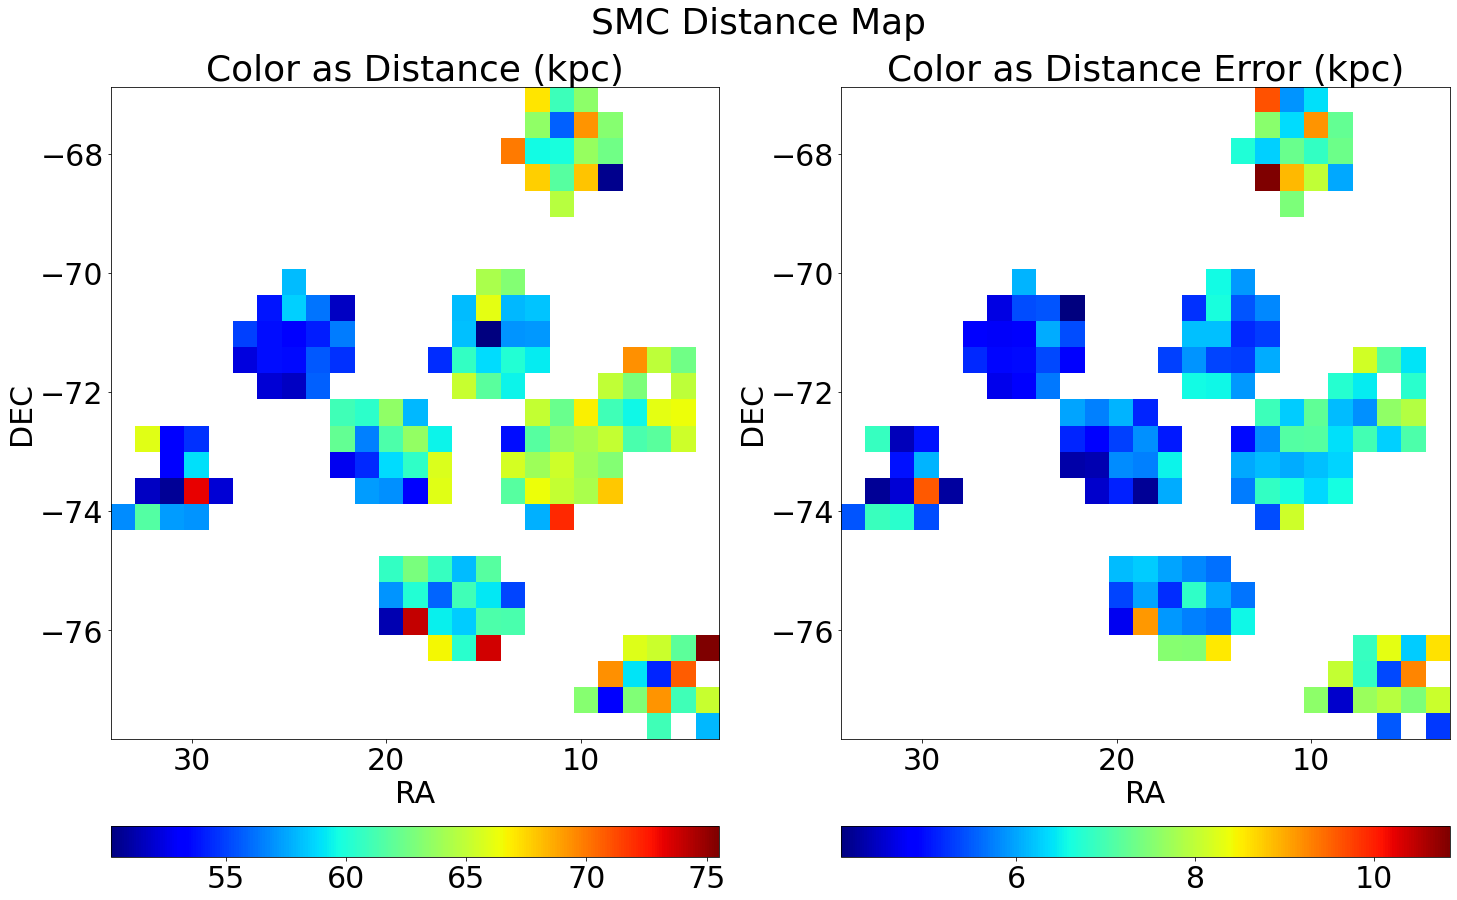

In [48]:
distmed = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance27pmEP['DISTANCE'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(distmed.statistic.T, origin='lower',
           extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map27pmEP.pdf',bbox_inches='tight')
plt.show()

#### 
disterr = binned_statistic_2d(smc['RA'],smc['DEC'],calc_distance27pmEP['DISTANCE_ERR'],'median',bins=25,
                              expand_binnumbers=True)
plt.figure(figsize=[12,10])
# N.statistic[N.statistic<2.] = np.nan
plt.imshow(disterr.statistic.T, origin='lower',
           extent=[disterr.x_edge[0],disterr.x_edge[-1],disterr.y_edge[0],disterr.y_edge[-1]],aspect='auto',
           interpolation='nearest', cmap='jet')

plt.colorbar()
plt.gca().invert_xaxis()

plt.title(r'Color as Distance Error [kpc]')
plt.xlabel(r'RA')
plt.ylabel('DEC')

plt.savefig('smc_distance_map27pmEP_err.pdf',bbox_inches='tight')
plt.show()

###
fig,ax = plt.subplots(1,2,figsize=[24,16])
im0 = ax[0].imshow(distmed.statistic.T, origin='lower',
                   extent=[distmed.x_edge[0],distmed.x_edge[-1],distmed.y_edge[0],distmed.y_edge[-1]],
                   aspect='auto',interpolation='nearest', cmap='jet')

im1 = ax[1].imshow(disterr.statistic.T, origin='lower',
                   extent=[disterr.x_edge[0],disterr.x_edge[-1],disterr.y_edge[0],disterr.y_edge[-1]],
                   aspect='auto',interpolation='nearest', cmap='jet')

ax[0].set_title(r'Color as Distance (kpc)')#,y=-0.19)
ax[1].set_title(r'Color as Distance Error (kpc)')#,y=-0.19)

for i in [0,1]:
    ax[i].invert_xaxis()
    ax[i].set_xlabel(r'RA')
    ax[i].set_ylabel(r'DEC')
    
fig.colorbar(im0,ax=ax[0],orientation='horizontal',pad=0.1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal',pad=0.1)

fig.suptitle(r'SMC Distance Map',y=0.95)

plt.savefig('distancemap27pmEP.pdf',bbox_inches='tight')
plt.show()

In [64]:
field_str = ['47TUC','N362','SMC1','SMC2','SMC3','SMC4','SMC5','SMC6','SMC7']
field_col = np.zeros(len(smc))
for i in range(len(field_idx)):
    if field_str[i] == '47TUC':
        field_col[field_idx[i]] = 0
        
    elif field_str[i] == 'N362':
        field_col[field_idx[i]] = 1

        
field_col = []
for i in range(len(smc)):

    if (smc['FIELD'][i]=='47TUC'): 
        field_col.append(8.)
        
    elif (smc['FIELD'][i]=='N362'): 
        field_col.append(9.)
        
    elif (smc['FIELD'][i]=='SMC1'): 
        field_col.append(1.)
        
    elif (smc['FIELD'][i]=='SMC2'): 
        field_col.append(2.)

    elif (smc['FIELD'][i]=='SMC3'): 
        field_col.append(3.)

    elif (smc['FIELD'][i]=='SMC4'): 
        field_col.append(4.)

    elif (smc['FIELD'][i]=='SMC5'): 
        field_col.append(5.)
        
    elif (smc['FIELD'][i]=='SMC6'): 
        field_col.append(6.)

    elif (smc['FIELD'][i]=='SMC7'): 
        field_col.append(7.)
        
field_col = np.asarray(field_col)

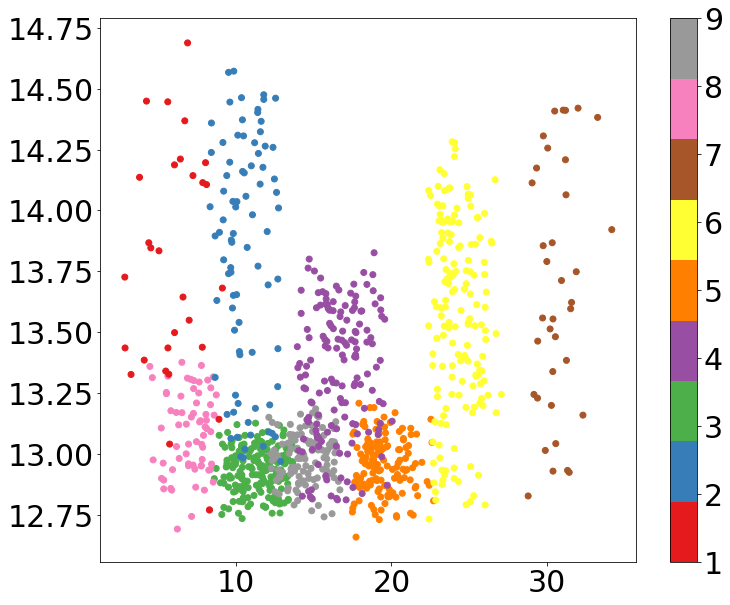

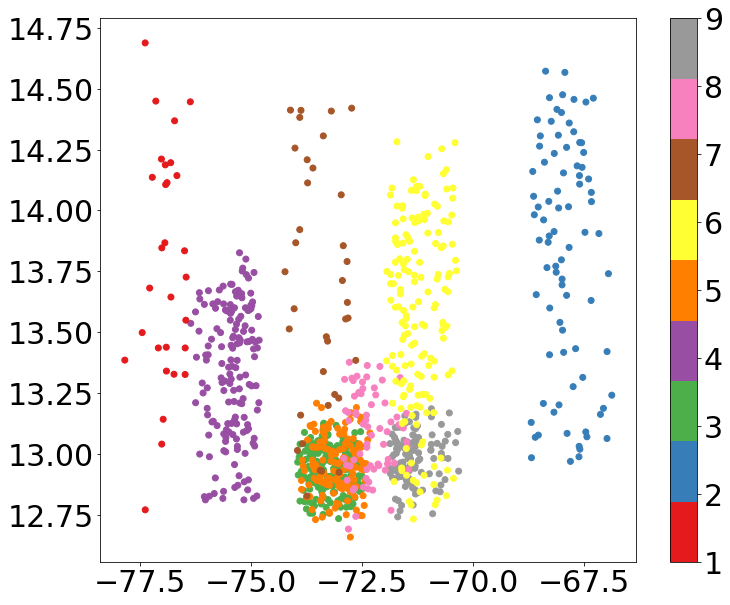

In [70]:
plt.figure(figsize=[12,10])
plt.scatter(smc['RA'],smc['K'],c=field_col,cmap='Set1')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(smc['DEC'],smc['K'],c=field_col,cmap='Set1')
plt.colorbar()
plt.show()

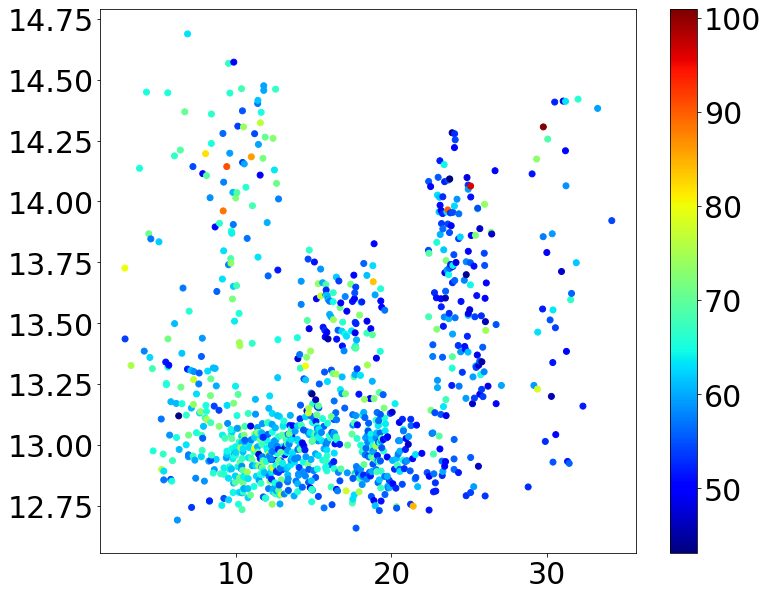

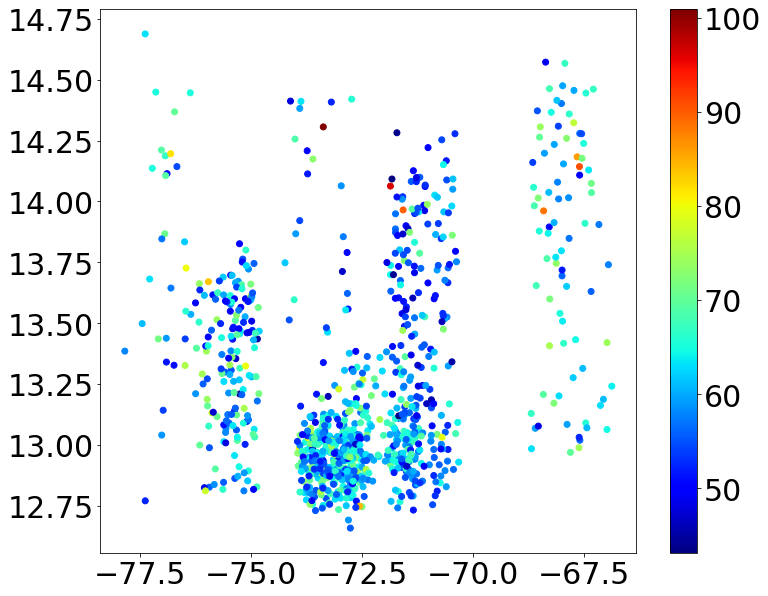

In [74]:
plt.figure(figsize=[12,10])
plt.scatter(smc['RA'],smc['K'],c=calc_distance27pmEP['DISTANCE'],cmap='jet')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(smc['DEC'],smc['K'],c=calc_distance27pmEP['DISTANCE'],cmap='jet')
plt.colorbar()
plt.show()

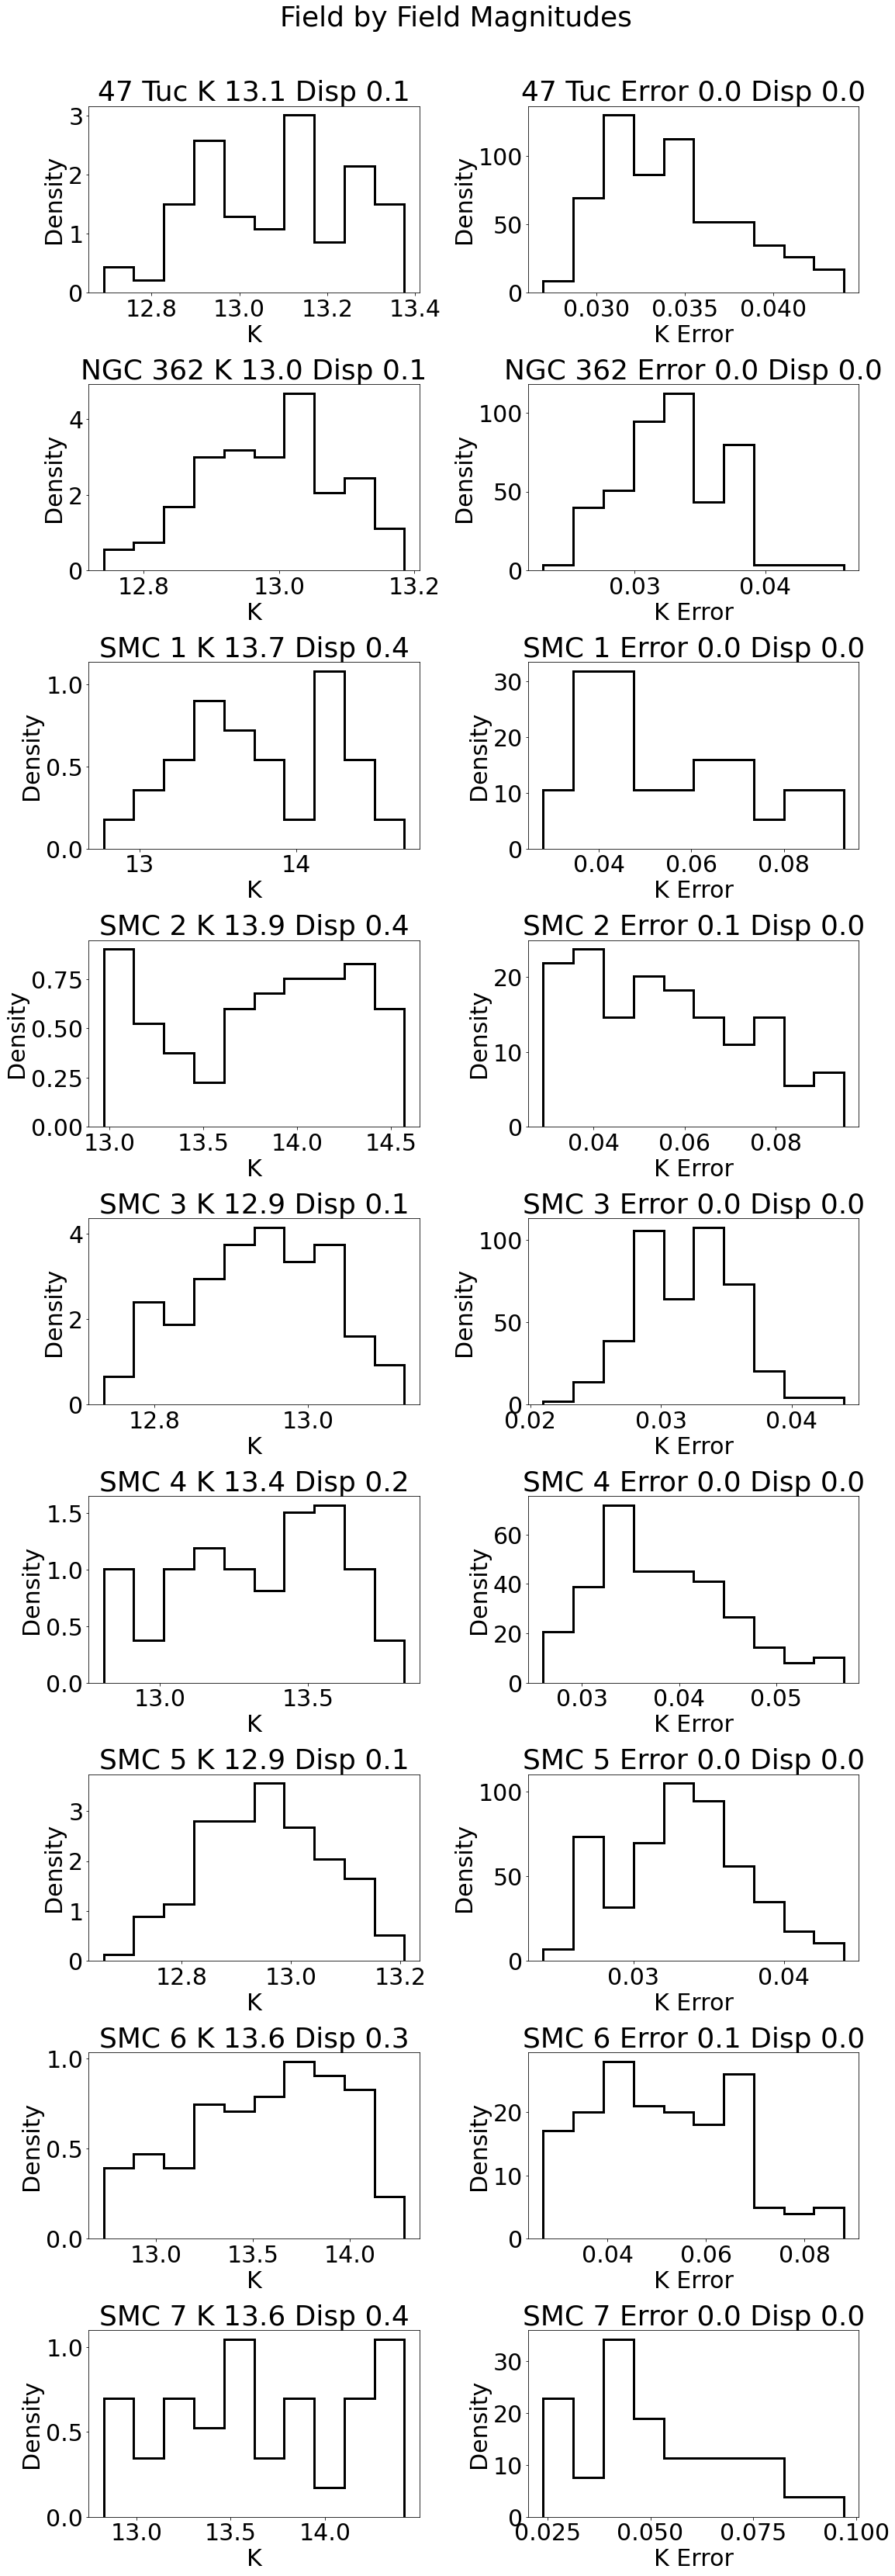

In [73]:
kmags = [smc[tuc47_ind]['K'],smc[n362_ind]['K'],smc[smc1_ind]['K'],smc[smc2_ind]['K'],smc[smc3_ind]['K'],
         smc[smc4_ind]['K'],smc[smc5_ind]['K'],smc[smc6_ind]['K'],smc[smc7_ind]['K']]

kmags_errs = [smc[tuc47_ind]['K_ERR'],smc[n362_ind]['K_ERR'],smc[smc1_ind]['K_ERR'],smc[smc2_ind]['K_ERR'],
              smc[smc3_ind]['K_ERR'],smc[smc4_ind]['K_ERR'],smc[smc5_ind]['K_ERR'],smc[smc6_ind]['K_ERR'],
              smc[smc7_ind]['K_ERR']]

field_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].hist(kmags[i],density=True,bins=10,histtype='step',lw=3.0,color='k')
    
#     ax[i][0].set_ylim(top=0.1)
#     ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'K')
    ax[i][0].set_ylabel(r'Density')
    
    ax[i][0].set_title(r'{} K {:.1f} Disp {:.1f}'.format(field_label[i],np.median(kmags[i]),
                                                         util.mad(kmags[i])))
    
#     ax[i][0].axvline(50,ls='--',c='b')
#     ax[i][0].axvline(60,ls='--',c='b')
#     ax[i][0].axvline(70,ls='--',c='b')
    
    ### Error Distributions
    ax[i][1].hist(kmags_errs[i],density=True,bins=10,histtype='step',lw=3.0,color='k')
    
#     ax[i][1].set_ylim(top=0.7)
#     ax[i][1].set_xlim(2.5,10.)
    ax[i][1].set_xlabel(r'K Error')
    ax[i][1].set_ylabel(r'Density')

    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(field_label[i],np.median(kmags_errs[i]),
                                                             util.mad(kmags_errs[i])))

plt.suptitle('Field by Field Magnitudes',y=1.025)
plt.tight_layout(pad=0.5)

plt.savefig('kmag_distribution.pdf',bbox_inches='tight')
plt.show()

ValueError: `bins` must increase monotonically, when an array

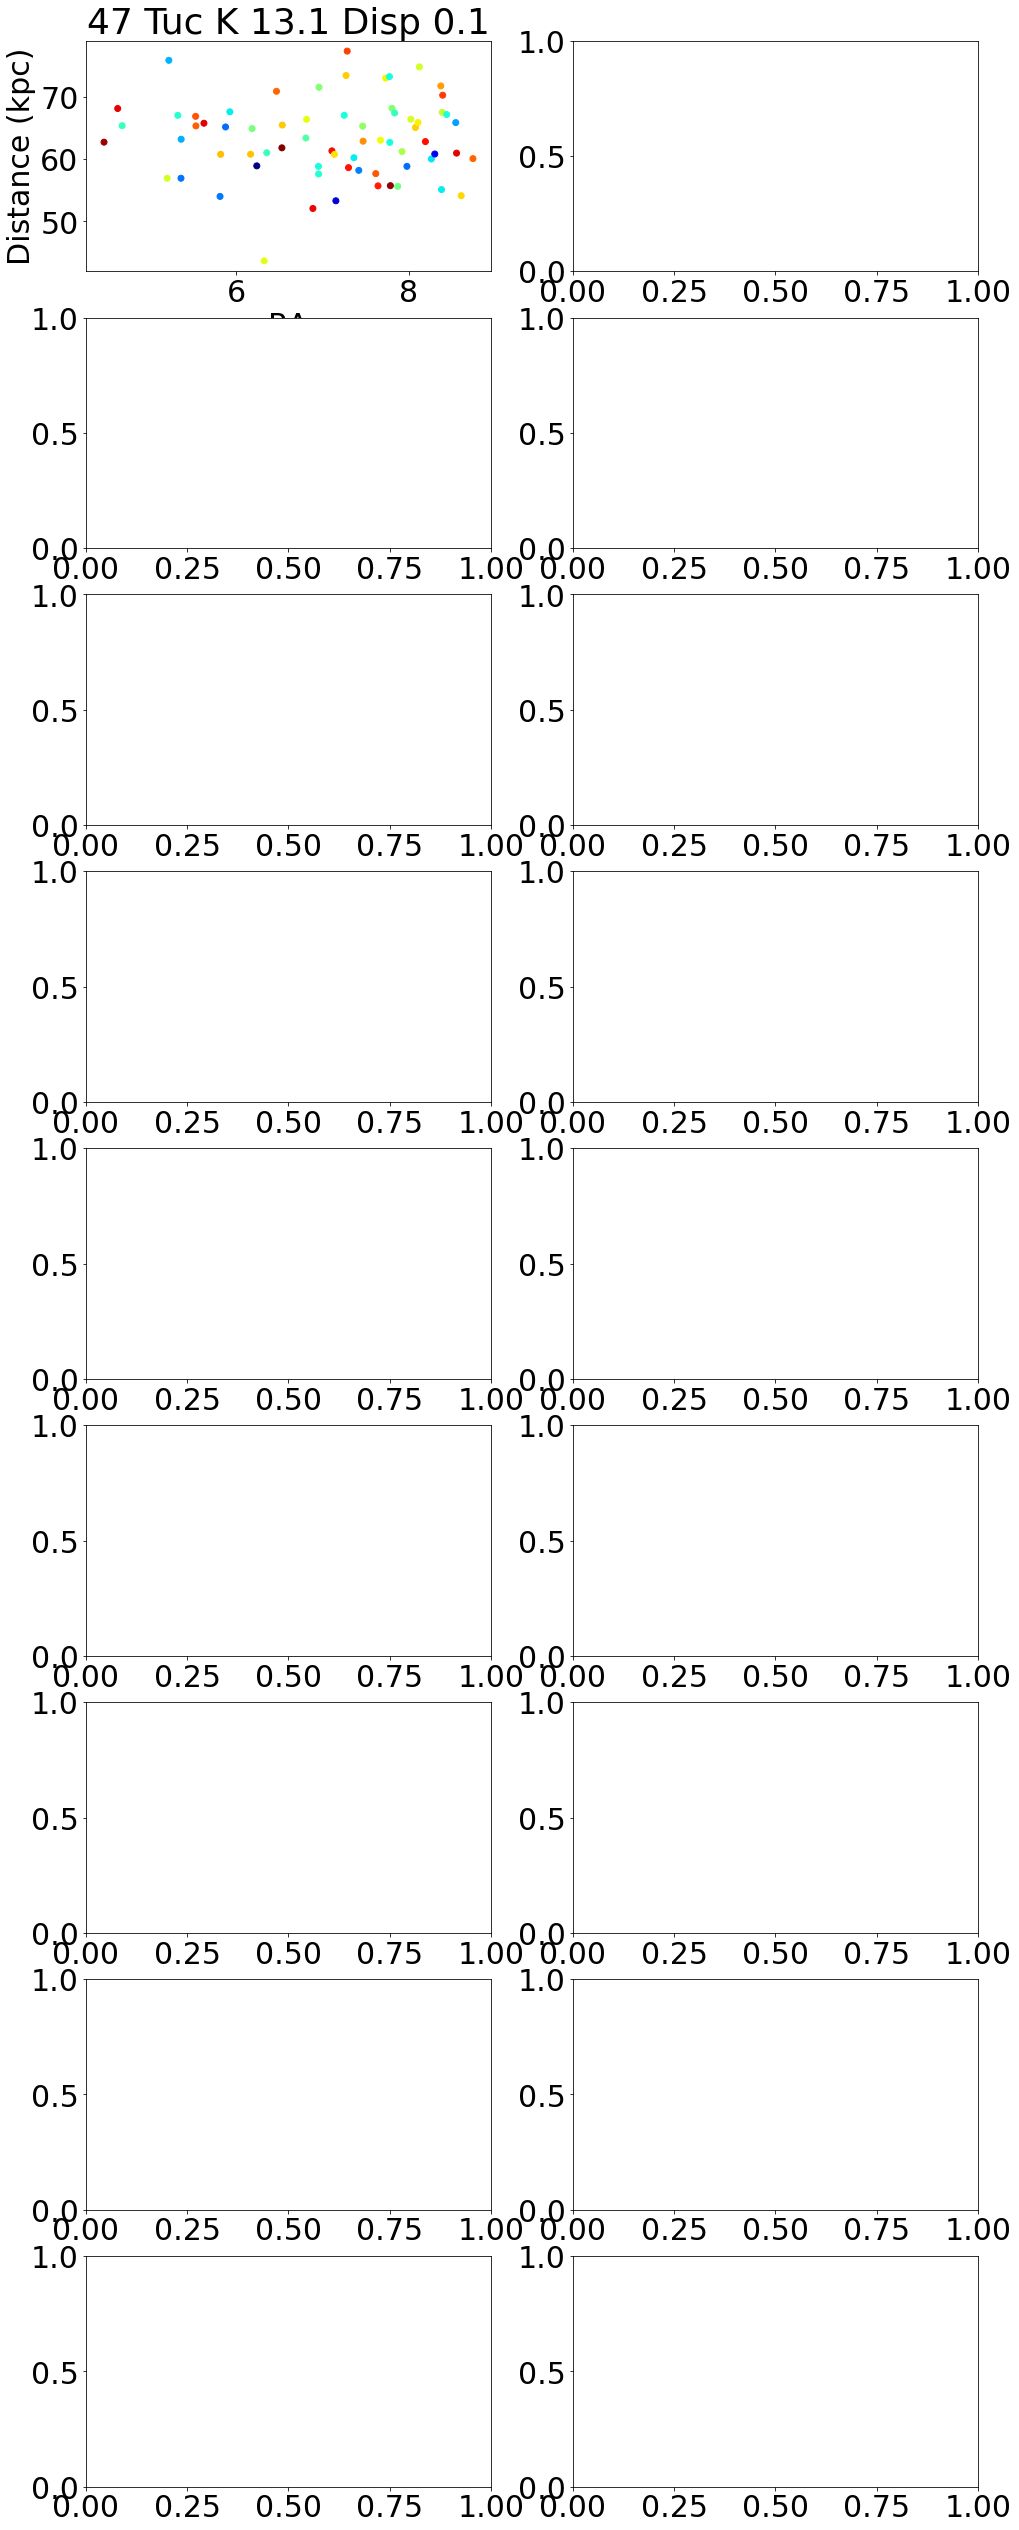

In [81]:
distance_kpdist = [tuc47_kpdist27pmEP,n362_kpdist27pmEP,smc1_kpdist27pmEP,smc2_kpdist27pmEP,smc3_kpdist27pmEP,
                   smc4_kpdist27pmEP,smc5_kpdist27pmEP,smc6_kpdist27pmEP,smc7_kpdist27pmEP]

kmags = [smc[tuc47_ind]['K'],smc[n362_ind]['K'],smc[smc1_ind]['K'],smc[smc2_ind]['K'],smc[smc3_ind]['K'],
         smc[smc4_ind]['K'],smc[smc5_ind]['K'],smc[smc6_ind]['K'],smc[smc7_ind]['K']]

kmags_errs = [smc[tuc47_ind]['K_ERR'],smc[n362_ind]['K_ERR'],smc[smc1_ind]['K_ERR'],smc[smc2_ind]['K_ERR'],
              smc[smc3_ind]['K_ERR'],smc[smc4_ind]['K_ERR'],smc[smc5_ind]['K_ERR'],smc[smc6_ind]['K_ERR'],
              smc[smc7_ind]['K_ERR']]

ras = [smc[tuc47_ind]['RA'],smc[n362_ind]['RA'],smc[smc1_ind]['RA'],smc[smc2_ind]['RA'],smc[smc3_ind]['RA'],
       smc[smc4_ind]['RA'],smc[smc5_ind]['RA'],smc[smc6_ind]['RA'],smc[smc7_ind]['RA']]

decs = [smc[tuc47_ind]['DEC'],smc[n362_ind]['DEC'],smc[smc1_ind]['DEC'],smc[smc2_ind]['DEC'],smc[smc3_ind]['DEC'],
       smc[smc4_ind]['DEC'],smc[smc5_ind]['DEC'],smc[smc6_ind]['DEC'],smc[smc7_ind]['DEC']]

field_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,45])

for i in range(len(ax)):
    ### Distance Distributions
    ax[i][0].scatter(ras[i],distance_kpdist[i],c=kmags[i],cmap='jet')
    
#     ax[i][0].set_ylim(top=0.1)
#     ax[i][0].set_xlim(40,100)
    ax[i][0].set_xlabel(r'RA')
    ax[i][0].set_ylabel(r'Distance (kpc)')
    
    ax[i][0].set_title(r'{} K {:.1f} Disp {:.1f}'.format(field_label[i],np.median(kmags[i]),
                                                         util.mad(kmags[i])))
    
    ### Error Distributions
    ax[i][1].hist(decs[i],distance_kpdist[i],c=kmags[i],cmap='jet')
    
#     ax[i][1].set_ylim(top=0.7)
#     ax[i][1].set_xlim(2.5,10.)
    ax[i][1].set_xlabel(r'DEC')
    ax[i][1].set_ylabel(r'Distance')

    ax[i][1].set_title(r'{} Error {:.1f} Disp {:.1f}'.format(field_label[i],np.median(kmags_errs[i]),
                                                             util.mad(kmags_errs[i])))

plt.suptitle('Magnitudes And Distances',y=1.025)
plt.tight_layout(pad=0.5)

# plt.savefig('kmag_distribution.pdf',bbox_inches='tight')
plt.show()